## Refugee Returnee Analysis – Afghanistan

In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import sys
from scipy.stats import chi2_contingency
import statsmodels.formula.api as smf
sys.path.append('../scripts')
from utils import descriptive_analysis, range_frequency_analysis, multiple_response_analysis
from viz import plot_bar_chart_with_percentage, plot_vertical_bar_chart_with_percentage

# Colors
colors = ['#005055', '#64afa0', '#6ec34b', '#198cc3']
color = '#005055'

In [3]:
# Temporarily expand all rows and columns for full display
pd.set_option('display.max_rows', None)       # Show all rows
pd.set_option('display.max_columns', None)    # Show all columns
pd.set_option('display.max_colwidth', None)   # Show full column contents
pd.set_option('display.width', 0)

In [4]:
# load the CEI dataset
data_file_path = '../data/afghan_returnee_dataset_24_03_2025.xlsx'
data = pd.read_excel(data_file_path)

### Understanding Data Structure

In [5]:
print("Dataset loaded successfully. Here are the first few rows:")
data.head()

Dataset loaded successfully. Here are the first few rows:


,today,username,agree_to_continue,[Enumerator: How many people refused to be interviewed before this interview?],Have you been interviewed in Afghanistan by the Mixed Migration Centre before?,Do you feel comfortable answering my questions at this time or do you want me to call another time?,[Enumerator: Do you feel you are undisturbed or other people are able to hear our conversation?],Who is present and listening?,Q16/Other migrants,Q16/Spouse,Q16/Child/children,Q16/Other family members,Q16/Local community elder/authority,Q16/Smuggler,Q16/Security forces/police/border authorities,Q16/Other,Please specify,[Enumerator: Means of recruitment],[Please specify means of recruitment],[Please specify referral from whom],[Can you specify the platform please?],[Please specify ],[Can you specify the name of page/group please?],[Please specify the name of the NGO/CSO],In what province/region are you in right now?,What town are you in right now?],Please specify2,Are you a national of Afghanistan?,What country did you return from?,Please specify3,R2_2,Do you remember when you arrived back in Afghanistan?,When did you arrive in Afghanistan?,num_of_days,"Do you migrate out of Afghanistan on a regular basis (e.g. every year, for seasonal work, for trade in other countries)?",How old are you?,[Enumerator observation: Sex],Are you currently living with children [under age 18] in your care?,How many children are you living with?,What is the highest level of education you have completed?,Please specify4,What is your province or region of origin?,What town or city are you from in your province of origin?,Please specify5,"Before you migrated, where in Afghanistan were you living?",For what reasons did you leave Afghanistan?,"Q78/Economic (e.g. unemployment, unable to earn enough, unable to maintain a business)","Q78/Violence, insecurity and conflict (e.g. war, terrorism, general crime and insecurity, domestic violence, gender-based violence)","Q78/Rights and freedoms (e.g. discrimination, persecution, repression, forced conscription)","Q78/Personal or family reasons (e.g. ill-health, death, divorce, family dispute, family reunification, get married)","Q78/Access to services/corruption (includes corruption and lack of access to services such as education, health, etc.)",Q78/Natural disaster or environmental factors,Q78/Culture of migration (tradition of moving away),Q78/Other,Q78/Don't know,Q78/Refused,Please specify6,How long did you spend in ${R2_2}${R2_1}?,What was your migration / legal status before you left ${R2_2}${R2_1},Please specify7,Were any family members with you in ${R2_2}${R2_1}?,Were you of school age while in ${R2_2}${R2_1} at any point?,Did you have any formal schooling in ${R2_2}${R2_1}?,Did you make any money in ${R2_2}${R2_1}?,How were you making money?,R25/Regular paid job,R25/Casual/occasional work,R25/Business owner/self-employed,R25/Other,R25/Refused,Please specify8,What kind of sector were you making money in?,R26/Driver / Transportation,R26/Domestic work,R26/Small business (shop/catering/services),R26/Agriculture / pastoralism / fishing,R26/Construction,R26/Industry / manufacturing,R26/Health worker,R26/Civil service / teaching,R26/Police / military,R26/Finance / IT,R26/Security,R26/Sex work,R26/Other,R26/Refused,Please specify9,"Did you acquire skills/qualifications while in ${R2_2}${R2_1}, that you think will improve or are improving your economic opportunities in Afghanistan?",R27/Literacy/numeracy,R27/Languages,R27/School-leaving certificates / qualifications,R27/Higher education diploma/degree,R27/Vocational qualifications,R27/How to set up a business,R27/IT skills,"R27/Practical/manual skills without qual. (e.g. driving, construction work etc)","R27/No, none",R27/Other,R27/Refused,Please specify10,What were your main expectations when migrating to ${R2_2}${R2_1}?,R27_2/To find better job opportunities,R27_2/To access better education for myself or my family,R27_2/To live in a safer and more secure environment,R27_2/To

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Columns: 564 entries, today to _submitted_by
dtypes: float64(129), int64(4), object(431)
memory usage: 3.2+ MB


### Summary Statistics

In [7]:
# distribution of numerical columns
pd.DataFrame(data.describe()).T

,count,mean,std,min,25%,50%,75%,max
[Enumerator: How many people refused to be interviewed before this interview?],740.0,2.189189e-01,0.546282,0.0,0.000000e+00,0.0,0.000000e+00,3.0
Q16/Smuggler,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q16/Security forces/police/border authorities,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q16/Other,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Please specify,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
[Please specify means of recruitment],0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
[Please specify ],0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
[Can you specify the name of page/group please?],0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Please specify2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Please specify3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data Cleaning
- Removing not neccessary columns
- Handling missing values, invalid data, etc.

In [7]:
# List of all columns to drop
columns_to_drop = [
    'audit',
    'instanceID',
    '_id',
    '_uuid',
    '_submission_time',
    '_submitted_by',
    'today',
    'username',
    'Do you understand all the information we just gave you, and do you agree to continue?'
]

# Drop columns only if they exist in the dataset
df = data.drop(columns=[col for col in columns_to_drop if col in data.columns])

In [9]:
# check columns with missing values
nul_cols = df.isnull().sum()
nul_cols = nul_cols[nul_cols > 0].sort_values(ascending=False)

print(nul_cols)

Please specify45                                                                                                                                                                  740
R27_2/Other                                                                                                                                                                       740
Please specify13                                                                                                                                                                  740
R56/Other                                                                                                                                                                         740
R36/Other                                                                                                                                                                         740
Please specify14                                                                          

In [10]:
# Remove the columns with no values
df = df.dropna(axis=1, how='all')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Columns: 428 entries, agree_to_continue to Q162/Technical / connection problems
dtypes: float64(1), int64(3), object(424)
memory usage: 2.4+ MB


### 🟡 MODULE 1: Informed Consent & Interview Context

#### Data Variables:
- Consent: Do you agree to continue?
- How many people refused before this interview?
- Are you comfortable answering now?
- Interview privacy: Is anyone listening?
- Who is present?
- Recruitment method

#### Descriptive Analysis Questions:
- % of respondents who gave consent
- Distribution of refusals before interview
- Privacy by gender/country
- Frequency of recruitment methods

#### Key Questions:
- Are males more likely to be interviewed privately?
- Does recruitment method vary by country?
- Does privacy influence response quality?

In [11]:
# Use exact column names from your dataset
col_consent = "agree_to_continue"
col_refusals = '[Enumerator: How many people refused to be interviewed before this interview?]'
col_comfort = 'Do you feel comfortable answering my questions at this time or do you want me to call another time?'
col_privacy = '[Enumerator: Do you feel you are undisturbed or other people are able to hear our conversation?]'
col_presence = 'Who is present and listening?'
col_recruitment = '[Enumerator: Means of recruitment]'
col_gender = '[Enumerator observation: Sex]'  # Ensure this column exists
col_country = 'What country did you return from?'

In [12]:
# 1. % of respondents who gave consent
consent_distribution = df[col_consent].value_counts(normalize=True) * 100
consent_distribution

agree_to_continue
Yes    100.0
Name: proportion, dtype: float64

In [13]:
# 2. Distribution of refusals before interview
refusal_distribution = df[col_refusals].value_counts().reset_index()
refusal_distribution

,[Enumerator: How many people refused to be interviewed before this interview?],count
0,0,624
1,1,71
2,2,44
3,3,1


In [14]:
# 3. Privacy by gender
# Frequency table
privacy_freq_gender = pd.crosstab(df[col_gender], df[col_privacy])

# Percentage table
privacy_percent_gender = pd.crosstab(df[col_gender], df[col_privacy], normalize='index') * 100

# Combine both
privacy_gender_combined = pd.concat([
    privacy_freq_gender.add_suffix(' (Freq)'),
    privacy_percent_gender.add_suffix(' (%)')
], axis=1)

# Display
privacy_gender_combined

[Enumerator: Do you feel you are undisturbed or other people are able to hear our conversation?],There are other people around and able to hear (Freq),Undisturbed (Freq),There are other people around and able to hear (%),Undisturbed (%)
[Enumerator observation: Sex],,,,
Female,49,155,24.019608,75.980392
Male,20,516,3.731343,96.268657


In [15]:
# 4. Privacy by country
# Frequency table (counts)
privacy_freq = pd.crosstab(df[col_country], df[col_privacy])

# Percentage table (row-wise normalized)
privacy_percent = pd.crosstab(df[col_country], df[col_privacy], normalize='index') * 100

# Combine both with multi-level columns
combined = pd.concat([privacy_freq.add_suffix(' (Freq)'), 
                      privacy_percent.add_suffix(' (%)')], axis=1)

# Optional: sort rows for cleaner display
combined = combined.sort_index()

# Show result
combined

[Enumerator: Do you feel you are undisturbed or other people are able to hear our conversation?],There are other people around and able to hear (Freq),Undisturbed (Freq),There are other people around and able to hear (%),Undisturbed (%)
What country did you return from?,,,,
Germany,1,0,100.000000,0.000000
India,1,0,100.000000,0.000000
Iran,14,262,5.072464,94.927536
Pakistan,42,297,12.389381,87.610619
Pakistan,0,1,0.000000,100.000000
Russia,0,1,0.000000,100.000000
Saudi Arabia,3,6,33.333333,66.666667
Tajikistan,1,3,25.000000,75.000000
Türkiye,4,99,3.883495,96.116505


In [15]:
# 5. Frequency of recruitment methods (as DataFrame with count + %)
recruitment_counts = df[col_recruitment].value_counts().reset_index()
recruitment_counts.columns = ['Recruitment Method', 'Frequency']

# Add percentage column
recruitment_counts['Percentage'] = (recruitment_counts['Frequency'] / recruitment_counts['Frequency'].sum()) * 100

# Display result
recruitment_counts

,Recruitment Method,Frequency,Percentage
0,Referral by acquaintance/friend,228,30.810811
1,Referral by community leaders,205,27.702703
2,NGOs/CSOs,201,27.162162
3,Neighborhoods,57,7.702703
4,Referral by family members,17,2.297297
5,Referral by other,16,2.162162
6,Home / Roommates,10,1.351351
7,Not applicable,5,0.675676
8,"Social networks (Facebook, Whatsapp, Badoo...)",1,0.135135


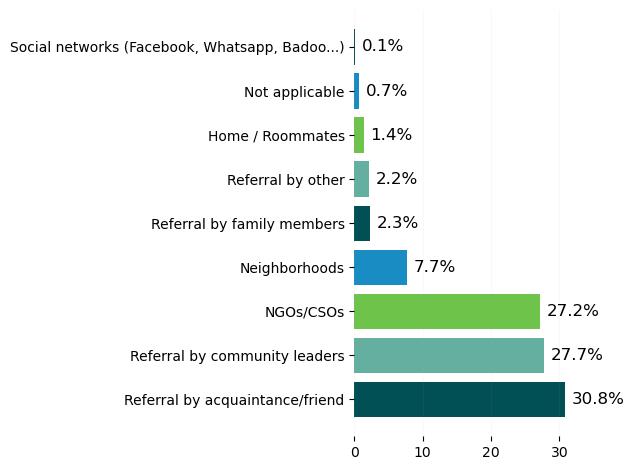

In [16]:
recruitment_df = df[col_recruitment].value_counts().reset_index()
recruitment_df.columns = ['Recruitment Method', 'Count']
plot_bar_chart_with_percentage(recruitment_df, 'Recruitment Method', 'Count', colors=colors)

In [18]:
from scipy.stats import chi2_contingency
# Generate crosstab with row percentages
privacy_by_gender = pd.crosstab(df[col_gender], df[col_privacy], normalize='index') * 100
print(privacy_by_gender)

# 6. Gender × Privacy
ct_gender_privacy = pd.crosstab(df[col_gender], df[col_privacy])
chi2_1, p_1, _, _ = chi2_contingency(ct_gender_privacy)
print(f"\nChi-square test (Gender × Privacy): χ² = {chi2_1:.2f}, p = {p_1:.4f}")

[Enumerator: Do you feel you are undisturbed or other people are able to hear our conversation?]  There are other people around and able to hear  \
[Enumerator observation: Sex]                                                                                                                      
Female                                                                                                                                 24.019608   
Male                                                                                                                                    3.731343   

[Enumerator: Do you feel you are undisturbed or other people are able to hear our conversation?]  Undisturbed  
[Enumerator observation: Sex]                                                                                  
Female                                                                                              75.980392  
Male                                                                   

##### Interpretation:
- A significantly higher proportion of males (96.27%) were interviewed without others hearing, compared to females (75.98%).
- Conversely, nearly 1 in 4 females (24%) were not fully private during the interview.
- The Chi-square result is highly significant (χ² = 69.56, p = 0.0000), confirming that this difference is not due to random chance

##### Recommendation:
-Males are substantially more likely to be interviewed privately than females. This highlights a gender gap in interview privacy and suggests the need for improved privacy protocols for female respondents — such as choosing better locations or implementing stricter confidentiality practices during fieldwork.

### Module 2: Basic Demographic and Current Location
#### Dataset Variables:
- How old are you?
- Enumerator observation: Sex
- What is your marital status?
- Are you currently living with children [under age 18] in your care?
- How many children are you living with?
- What is the highest level of education you have completed?
- 'In what province/region are you in right now?'
- Are you a national of Afghanistan?'

In [17]:
# Variable names
col_age = 'How old are you?'
col_gender = '[Enumerator observation: Sex]'
col_marital = 'What is your marital status?'
col_living_with_children = 'Are you currently living with children [under age 18] in your care?'
col_num_children = 'How many children are you living with?'
col_education = 'What is the highest level of education you have completed?'
currrent_location = 'In what province/region are you in right now?'
nationality = 'Are you a national of Afghanistan?'

In [18]:
columns_to_analyze = {
    "Gender": col_gender,
    "Education Level": col_education,
    "Current Location": currrent_location,
    "Nationality": nationality
}

# Run the function
results = descriptive_analysis(df, columns_to_analyze)

In [19]:
# 1. Gender ratio
results['Gender']

,Gender,Frequency,Percentage
0,Male,536,72.43
1,Female,204,27.57


In [20]:
# Education level ratio
results['Education Level']

,Education Level,Frequency,Percentage
0,Did not complete any schooling,324,43.78
1,Primary school,164,22.16
2,Secondary or high school,109,14.73
3,Primary school (religious),100,13.51
4,University degree,26,3.51
5,Vocational training,10,1.35
6,Refused,7,0.95


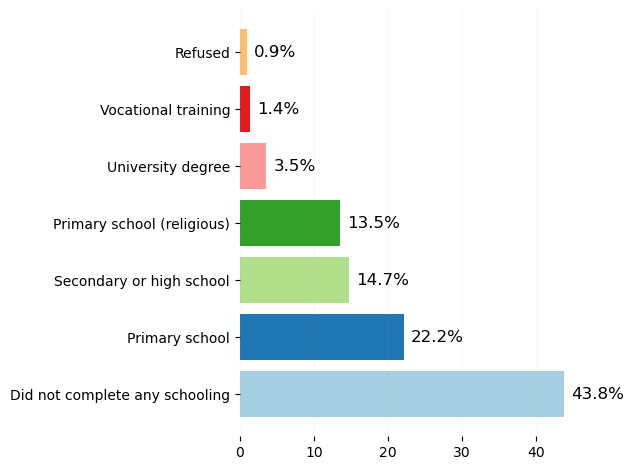

In [21]:
# Get value counts for Education Level
education_df = df[col_education].value_counts().reset_index()
education_df.columns = ['Education Level', 'Count']

# Optional: define color palette (or use any consistent list of colors)
colors = plt.cm.Paired.colors[:len(education_df)]

# Call the vertical plot function
plot_bar_chart_with_percentage(education_df, 'Education Level', 'Count', colors)


In [22]:
# Are all afghan naitonals?
results['Nationality']

,Nationality,Frequency,Percentage
0,"Yes, I was born here",740,100.0


In [23]:
# Current city of location
results['Current Location']

,Current Location,Frequency,Percentage
0,Kabul,197,26.62
1,Kandahar,147,19.86
2,Balkh,139,18.78
3,Nangarhar,130,17.57
4,Herat,109,14.73
5,Badakhshan,5,0.68
6,Uruzgan,3,0.41
7,Helmand,3,0.41
8,Zabul,2,0.27
9,Ghazni,1,0.14


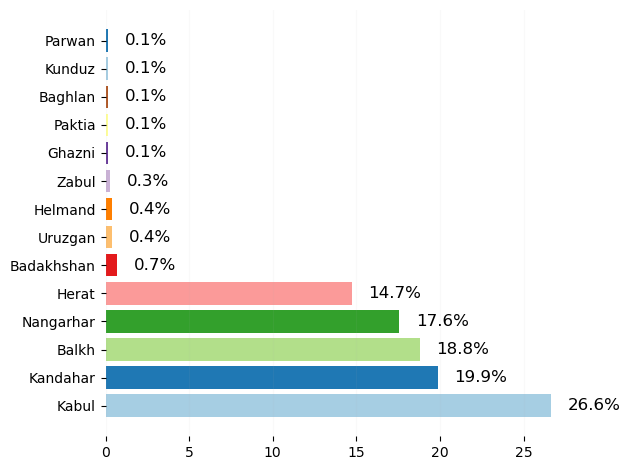

In [24]:
# Get value counts for Current Location
location_df = df[currrent_location].value_counts().reset_index()
location_df.columns = ['Current Location', 'Count']

# Optional: define color palette
colors = plt.cm.Paired.colors[:len(location_df)]

# Call the vertical plot function
plot_bar_chart_with_percentage(location_df, 'Current Location', 'Count', colors)

In [25]:
# 2. Children per household
children_counts = df[col_num_children].value_counts().reset_index()
children_counts.columns = ['Number of Children', 'Frequency']
children_counts['Percentage'] = (children_counts['Frequency'] / children_counts['Frequency'].sum() * 100).round(1)
children_counts

,Number of Children,Frequency,Percentage
0,3.0,87,21.3
1,4.0,79,19.3
2,2.0,73,17.8
3,5.0,52,12.7
4,6.0,34,8.3
5,1.0,33,8.1
6,7.0,18,4.4
7,8.0,15,3.7
8,9.0,7,1.7
9,10.0,5,1.2


In [26]:
from scipy.stats import ttest_ind

# Drop missing values
age_gender_df = df[[col_gender, col_age]].dropna()

# Split age by gender
female_ages = age_gender_df[age_gender_df[col_gender] == 'Female'][col_age]
male_ages = age_gender_df[age_gender_df[col_gender] == 'Male'][col_age]

# Run independent t-test
t_stat, p_val = ttest_ind(female_ages, male_ages, equal_var=False)  # Welch's t-test

# Output results
print(f"T-test Result: t = {t_stat:.2f}, p = {p_val:.4f}")
print(f"Mean Age - Female: {female_ages.mean():.1f}")
print(f"Mean Age - Male  : {male_ages.mean():.1f}")

T-test Result: t = 4.59, p = 0.0000
Mean Age - Female: 36.5
Mean Age - Male  : 32.5


**Conclusion**: Women returnees are significantly older than male returnees, with the difference being statistically significant (p < 0.001).

#### 🔵 MODULE 3: Migration History and Legal Status
- Migration experiences, legal status abroad, detention, and deportation experiences.

##### Data Variables:
- Country of return
- Nationality
- Date of return, frequency of migration
- Age, sex, education

##### Descriptive Analysis:
- Returnee count by country
- Age distribution histogram
- Education level % by gender

##### Inferential Analysis:
- ANOVA: Age by country of return
- Chi-square: Gender × Regularity of migration

#### A. Migration History

In [27]:
# Define exact column names based on your dataset
col_country_return = 'What country did you return from?'
col_return_in_days = 'num_of_days' # to count the return days
col_migrate_freq = 'Do you migrate out of Afghanistan on a regular basis (e.g. every year, for seasonal work, for trade in other countries)?'
col_age = 'How old are you?'
col_gender = '[Enumerator observation: Sex]'
col_education = 'What is the highest level of education you have completed?'
col_province_origin = 'What is your province or region of origin?'
col_province_current = 'In what province/region are you in right now?'
col_leave_afghanistan_reasons = 'For what reasons did you leave Afghanistan?'
col_return_type = 'For what reasons did you return to Afghanistan? You can give more than one reason'
col_stay_duration_migration_country = 'How long did you spend in the country of migration (${R2_2}${R2_1})?'
col_family_members_during_stay = 'Were any family members with you in the country of migration (${R2_2}${R2_1})?'

In [28]:
analysis_cols = {
    "Return Count by Country": col_country_return
}

migration_exp = descriptive_analysis(df, columns=analysis_cols)

In [29]:
# 1. Returnee count by country
migration_exp['Return Count by Country']

,Return Count by Country,Frequency,Percentage
0,Pakistan,339,45.81
1,Iran,276,37.30
2,Türkiye,103,13.92
3,Saudi Arabia,9,1.22
4,Tajikistan,4,0.54
5,Uzbekistan,4,0.54
6,Russia,1,0.14
7,Germany,1,0.14
8,United Kingdom,1,0.14
9,Pakistan,1,0.14


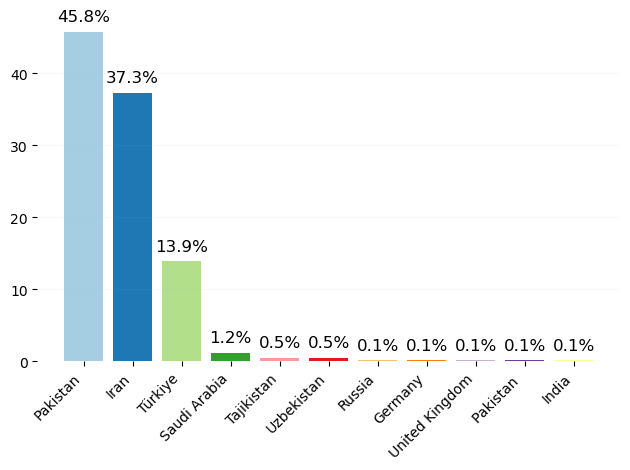

In [30]:
# Step 1: Get value counts
return_df = df[col_country_return].value_counts().reset_index()
return_df.columns = ['Return Country', 'Count']

# Step 2: Assign colors (optional)
colors = plt.cm.Paired.colors[:len(return_df)]

# Step 3: Plot using vertical bar chart
plot_vertical_bar_chart_with_percentage(
    return_df,
    category_column='Return Country',
    count_column='Count',
    colors=colors
)

In [31]:
# 2. Returned Duration in Days
# Example column and custom bin setup
bins = [180, 600, 800, 1000, 2000]
labels = ['180–599 days', '600–799 days', '800–999 days', '1000–2000 days']

# Run general range frequency analysis
range_df = range_frequency_analysis(df, col_return_in_days, bins, labels)

# Show results
range_df

,Range,Frequency,Percentage
0,180–599 days,495,66.89
1,600–799 days,114,15.41
2,800–999 days,32,4.32
3,1000–2000 days,99,13.38


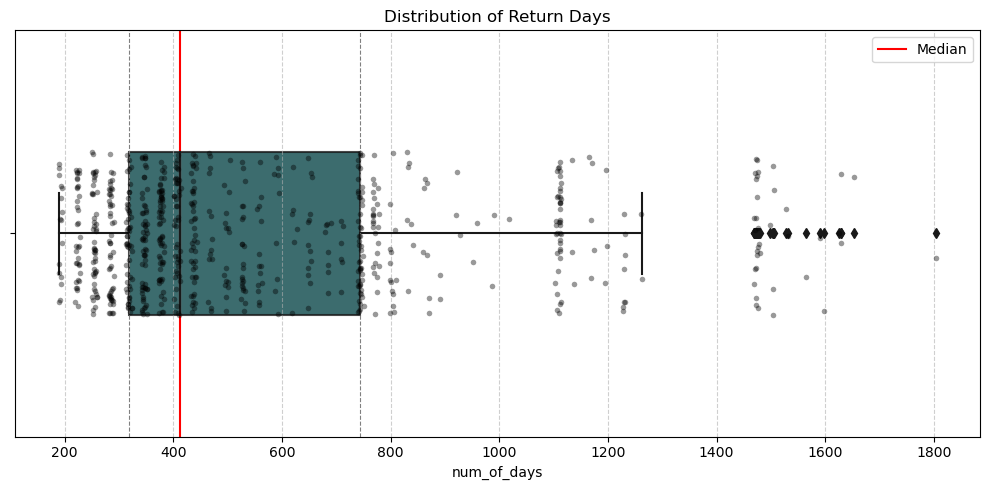

In [32]:
# Box plot to show the return in days duration for minimum, max, median, first quartile, second and third quartile.
def plot_custom_boxplot(df, numeric_col, title=None, color='skyblue', colors=None):
    """
    Plots a styled boxplot with overlaid data points and summary stats.

    Parameters:
    - df: pandas DataFrame
    - numeric_col: string, name of the numeric column to plot
    - title: optional string for plot title
    - color: string, single color for the boxplot (default: skyblue)
    - colors: list of colors (used if plotting multiple categories, e.g., hue or group)
    """

    if numeric_col not in df.columns:
        raise ValueError(f"Column '{numeric_col}' not found in the DataFrame.")

    plt.figure(figsize=(10, 5))

    # Box plot
    sns.boxplot(
        x=df[numeric_col],
        color=color if not colors else None,
        palette=colors if colors else None,
        width=0.4,
        boxprops=dict(alpha=0.8)
    )

    # Add individual data points (strip plot)
    sns.stripplot(
        x=df[numeric_col],
        color='black',
        size=4,
        jitter=0.2,
        alpha=0.4
    )

    # Annotate stats
    stats = df[numeric_col].describe()
    plt.axvline(stats['25%'], color='grey', linestyle='--', linewidth=0.8)
    plt.axvline(stats['50%'], color='red', linestyle='-', linewidth=1.5, label='Median')
    plt.axvline(stats['75%'], color='grey', linestyle='--', linewidth=0.8)

    # Label
    plt.title(title if title else f'Boxplot of {numeric_col}')
    plt.xlabel(numeric_col)
    plt.grid(True, axis='x', linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
plot_custom_boxplot(df, 'num_of_days', title='Distribution of Return Days', color=color)

In [33]:
# Frequency and percentage crosstabs
prov_country_crosstab = pd.crosstab(df[col_country_return], df[col_province_origin])
prov_country_percent = pd.crosstab(df[col_country_return], df[col_province_origin], normalize='index') * 100

# Create long-format DataFrame
country_prov_df = []
for country in prov_country_crosstab.index:
    for prov in prov_country_crosstab.columns:
        freq = prov_country_crosstab.loc[country, prov]
        if freq == 0:
            continue  # skip zero-frequency cells
        perc = prov_country_percent.loc[country, prov]
        country_prov_df.append({
            'Country of Return': country,
            'Province of Origin': prov,
            'Frequency': freq,
            'Percentage': round(perc, 1)
        })

# Convert to DataFrame
country_province_df = pd.DataFrame(country_prov_df)

# Optional: sort by country and frequency
country_province_df = country_province_df.sort_values(['Country of Return', 'Frequency'], ascending=[True, False])

In [34]:
# Step 1: Compute total returnees per country
country_totals = country_province_df.groupby('Country of Return')['Frequency'].sum().reset_index()
country_totals.columns = ['Country of Return', 'Total Frequency']

# Step 2: Merge totals with your long-format table
country_province_df = country_province_df.merge(country_totals, on='Country of Return')

# Step 3: Sort by total frequency first, then by province frequency
country_province_df = country_province_df.sort_values(
    ['Total Frequency', 'Frequency'], ascending=[False, False]
)

# Step 4: Drop helper column if you don't want it in the output
country_province_df = country_province_df.drop(columns=['Total Frequency'])

# Display full sorted result
pd.set_option('display.max_rows', None)
display(country_province_df)

,Country of Return,Province of Origin,Frequency,Percentage
23,Pakistan,Kandahar,101,29.8
24,Pakistan,Nangarhar,76,22.4
25,Pakistan,Kabul,60,17.7
26,Pakistan,Balkh,19,5.6
27,Pakistan,Helmand,12,3.5
28,Pakistan,Kunar,12,3.5
29,Pakistan,Kunduz,9,2.7
30,Pakistan,Jowzjan,7,2.1
31,Pakistan,Paktia,6,1.8
32,Pakistan,Badakhshan,5,1.5


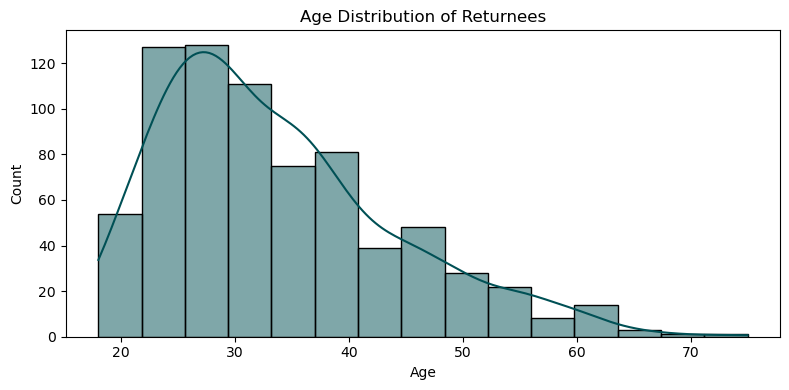

In [35]:
# Age distribution histogram
plt.figure(figsize=(8,4))
sns.histplot(df[col_age], bins=15, kde=True, color=color)
plt.title("Age Distribution of Returnees")
plt.xlabel("Age")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [ ]:
# Education Level
# Step 1: Clean gender and education columns
df[col_gender] = df[col_gender].astype(str).str.strip().str.title()
df[col_education] = df[col_education].astype(str).str.strip().str.title()

# Step 2: Frequency table
education_freq = pd.crosstab(df[col_gender], df[col_education])

# Step 3: Percentage table (row-wise % within gender)
education_pct = pd.crosstab(df[col_gender], df[col_education], normalize='index') * 100
education_pct = education_pct.round(1)

education_pct

What is the highest level of education you have completed?,Did Not Complete Any Schooling,Primary School,Primary School (Religious),Refused,Secondary Or High School,University Degree,Vocational Training
[Enumerator observation: Sex],,,,,,,
Female,57.4,10.3,18.1,0.0,10.8,2.0,1.5
Male,38.6,26.7,11.8,1.3,16.2,4.1,1.3


In [39]:
# question: Do you migrate out of Afghanistan on a regular basis (e.g. every year, for seasonal work, for trade in other countries)?
    # "Yes": The respondent reports they regularly leave Afghanistan for work, trade, or similar reasons.
    #"No": The respondent does not engage in regular migration outside Afghanistan.

print(df[col_migrate_freq].value_counts())  # example

Do you migrate out of Afghanistan on a regular basis (e.g. every year, for seasonal work, for trade in other countries)?
No    740
Name: count, dtype: int64


In [20]:
# the reasons to left Afghanistan for Migration

q78_columns = {
    "Economic (unemployment, insufficient income)": "Q78/Economic (e.g. unemployment, unable to earn enough, unable to maintain a business)",
    "Violence, insecurity, and conflict": "Q78/Violence, insecurity and conflict (e.g. war, terrorism, general crime and insecurity, domestic violence, gender-based violence)",
    "Rights and freedoms issues (persecution, forced conscription)": "Q78/Rights and freedoms (e.g. discrimination, persecution, repression, forced conscription)",
    "Personal or family reasons (health, family disputes, reunification)": "Q78/Personal or family reasons (e.g. ill-health, death, divorce, family dispute, family reunification, get married)",
    "Access to services/corruption": "Q78/Access to services/corruption (includes corruption and lack of access to services such as education, health, etc.)",
    "Natural disaster or environmental factors": "Q78/Natural disaster or environmental factors",
    "Culture of migration": "Q78/Culture of migration (tradition of moving away)",
    "Other reasons": "Q78/Other",
    "Don not Know": "Q78/Don't know",
    "Refused": "Q78/Refused"
}

# Run the analysis
q78_analysis = multiple_response_analysis(df, q78_columns, question_label="Reasons for Leaving Afghanistan")

# View result
q78_analysis

,Reason,Frequency,Percentage
0,"Reasons for Leaving Afghanistan – Economic (unemployment, insufficient income)",653,88.24
1,"Reasons for Leaving Afghanistan – Violence, insecurity, and conflict",310,41.89
2,"Reasons for Leaving Afghanistan – Rights and freedoms issues (persecution, forced conscription)",30,4.05
3,"Reasons for Leaving Afghanistan – Personal or family reasons (health, family disputes, reunification)",44,5.95
4,Reasons for Leaving Afghanistan – Access to services/corruption,61,8.24
5,Reasons for Leaving Afghanistan – Natural disaster or environmental factors,5,0.68
6,Reasons for Leaving Afghanistan – Culture of migration,5,0.68
7,Reasons for Leaving Afghanistan – Other reasons,1,0.14
8,Reasons for Leaving Afghanistan – Don not Know,0,0.00
9,Reasons for Leaving Afghanistan – Refused,0,0.00


In [33]:
# Reivew of Reasons by Country of Return 
# Run the analysis
q78_analysis = multiple_response_analysis(df, q78_columns, question_label="Reasons for Leaving Afghanistan", group_by='R2_2')

# View result
q78_analysis

,R2_2,"Economic (unemployment, insufficient income)","Violence, insecurity, and conflict","Rights and freedoms issues (persecution, forced conscription)","Personal or family reasons (health, family disputes, reunification)",Access to services/corruption,Natural disaster or environmental factors,Culture of migration,Other reasons,Don not Know,Refused
0,Germany,0 (0.0%),0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
1,Iran,271 (98.19%),20 (7.25%),5 (1.81%),9 (3.26%),5 (1.81%),0 (0.0%),2 (0.72%),0 (0.0%),0 (0.0%),0 (0.0%)
2,Other country,6 (54.55%),4 (36.36%),3 (27.27%),0 (0.0%),1 (9.09%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
3,Pakistan,274 (80.83%),247 (72.86%),18 (5.31%),14 (4.13%),45 (13.27%),4 (1.18%),1 (0.29%),1 (0.29%),0 (0.0%),0 (0.0%)
4,Pakistan,0 (0.0%),1 (100.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
5,Russia,1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
6,Saudi Arabia,2 (66.67%),0 (0.0%),0 (0.0%),1 (33.33%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
7,Tajikistan,1 (50.0%),0 (0.0%),0 (0.0%),0 (0.0%),1 (50.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
8,Türkiye,97 (94.17%),37 (35.92%),3 (2.91%),18 (17.48%),9 (8.74%),1 (0.97%),1 (0.97%),0 (0.0%),0 (0.0%),0 (0.0%)
9,United Kingdom,0 (0.0%),1 (100.0%),0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)


In [41]:
# How long did you spend in the migrated country?

# Define your columns
columns_to_analyze = {
    "time_duration_in_migrated_country": "How long did you spend in ${R2_2}${R2_1}?",
    "Any Family Member During Stay in Migrated Country": "Were any family members with you in ${R2_2}${R2_1}?"
}

# Run the function
results = descriptive_analysis(df, columns_to_analyze)

results['time_duration_in_migrated_country']

,time_duration_in_migrated_country,Frequency,Percentage
0,2-5 years,256,34.59
1,6 months to 2 years,241,32.57
2,5-10 years,91,12.30
3,10-20 years,73,9.86
4,1-6 months,53,7.16
5,20 years or more,22,2.97
6,Less than 1 month,4,0.54


In [36]:
# Reivew of stay duration by country of return

results = descriptive_analysis(df, columns_to_analyze, group_by='R2_2')

results['time_duration_in_migrated_country']

How long did you spend in ${R2_2}${R2_1}?,1-6 months,10-20 years,2-5 years,20 years or more,5-10 years,6 months to 2 years,Less than 1 month
R2_2,,,,,,,
Germany,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%)
Iran,27 (9.8%),0 (0.0%),90 (32.6%),0 (0.0%),10 (3.6%),147 (53.3%),2 (0.7%)
Other country,2 (18.2%),0 (0.0%),4 (36.4%),0 (0.0%),3 (27.3%),2 (18.2%),0 (0.0%)
Pakistan,8 (2.4%),71 (20.9%),127 (37.5%),21 (6.2%),70 (20.6%),42 (12.4%),0 (0.0%)
Pakistan,1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
Russia,0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
Saudi Arabia,0 (0.0%),0 (0.0%),1 (33.3%),0 (0.0%),1 (33.3%),1 (33.3%),0 (0.0%)
Tajikistan,1 (50.0%),0 (0.0%),1 (50.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
Türkiye,14 (13.6%),2 (1.9%),31 (30.1%),1 (1.0%),5 (4.8%),48 (46.6%),2 (1.9%)


In [42]:
# Were any family members with you in ${R2_2}${R2_1}?
results['Any Family Member During Stay in Migrated Country']

,Any Family Member During Stay in Migrated Country,Frequency,Percentage
0,Yes,434,58.65
1,No,306,41.35


#### B. Legal Status Abroad
Key Variables:
- What was your migration/legal status before you left the country of migration (${R2_2}${R2_1})?
- What were your main expectations when migrating to the country of migration (${R2_2}${R2_1})?
- What were the reasons you returned related to your legal status in the country of migration (${R2_2}${R2_1})?
- Were you held in detention relating to your migration status before leaving the country of migration?
    - For how long were you held in detention? (Variable: R34_1)

In [48]:
legar_status_analysis = {
    'Migration/Legal Status During Stay in Migration Country': 'What was your migration / legal status before you left ${R2_2}${R2_1}'
}

legal_Status = descriptive_analysis(df, legar_status_analysis, group_by='R2_2')

In [49]:
# What was your migration/legal status before you left the country of migration (${R2_2}${R2_1})?
legal_Status['Migration/Legal Status During Stay in Migration Country']

What was your migration / legal status before you left ${R2_2}${R2_1},Asylum seeker,Irregular/no legal documents to stay in this country,Permit is no longer valid/ expired,Refugee,Refused,Regular migrant with no need for permit,Student visa,Temporary protection,Temporary resident (with permit/visa)
R2_2,,,,,,,,,
Germany,1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
Iran,12 (4.4%),233 (84.4%),0 (0.0%),7 (2.5%),1 (0.4%),0 (0.0%),0 (0.0%),1 (0.4%),22 (8.0%)
Other country,1 (9.1%),3 (27.3%),3 (27.3%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),1 (9.1%),3 (27.3%)
Pakistan,62 (18.3%),237 (69.9%),2 (0.6%),26 (7.7%),0 (0.0%),3 (0.9%),0 (0.0%),4 (1.2%),5 (1.5%)
Pakistan,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),1 (100.0%)
Russia,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),1 (100.0%)
Saudi Arabia,0 (0.0%),3 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
Tajikistan,0 (0.0%),1 (50.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),1 (50.0%)
Türkiye,3 (2.9%),84 (81.6%),3 (2.9%),8 (7.8%),0 (0.0%),0 (0.0%),2 (1.9%),0 (0.0%),3 (2.9%)


In [51]:
r31_columns = {
    "Reasons related to my legal status in the country of migration / I was expelled / deported":
        "R31/Reasons related to my legal status in the country of migration / I was expelled / deported",
    "Reasons related to general living conditions in country of migration":
        "R31/Reasons related to general living conditions in country of migration",
    "Reasons related to conditions in country of origin":
        "R31/Reasons related to conditions in country of origin",
    "Personal reasons":
        "R31/Personal reasons",
    "Opportunity to benefit from AVR programme":
        "R31/Opportunity to benefit from AVR programme",
    "Other":
        "R31/Other",
    "Don't know":
        "R31/Don't know",
    "Refused":
        "R31/Refused",
    "Please specify":
        "Please specify11"
}

r31_return_reason = multiple_response_analysis(df, r31_columns, question_label="Reasons for Returning",)
r31_return_reason


,Reason,Frequency,Percentage
0,Reasons for Returning – Reasons related to my legal status in the country of migration / I was expelled / deported,590,79.73
1,Reasons for Returning – Reasons related to general living conditions in country of migration,212,28.65
2,Reasons for Returning – Reasons related to conditions in country of origin,50,6.76
3,Reasons for Returning – Personal reasons,80,10.81
4,Reasons for Returning – Opportunity to benefit from AVR programme,57,7.70
5,Reasons for Returning – Other,0,0.00
6,Reasons for Returning – Don't know,0,0.00
7,Reasons for Returning – Refused,0,0.00
8,Reasons for Returning – Please specify,0,0.00


In [52]:
# Review of return reasons by country of migration

r31_by_province = multiple_response_analysis(df, r31_columns, question_label="Reasons for Returning", group_by='R2_2')
r31_by_province

,R2_2,Reasons related to my legal status in the country of migration / I was expelled / deported,Reasons related to general living conditions in country of migration,Reasons related to conditions in country of origin,Personal reasons,Opportunity to benefit from AVR programme,Other,Don't know,Refused,Please specify
0,Germany,0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
1,Iran,228 (82.61%),69 (25.0%),8 (2.9%),33 (11.96%),4 (1.45%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
2,Other country,1 (9.09%),4 (36.36%),0 (0.0%),7 (63.64%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
3,Pakistan,286 (84.37%),105 (30.97%),37 (10.91%),27 (7.96%),31 (9.14%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
4,Pakistan,1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
5,Russia,0 (0.0%),1 (100.0%),0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
6,Saudi Arabia,1 (33.33%),0 (0.0%),0 (0.0%),1 (33.33%),1 (33.33%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
7,Tajikistan,0 (0.0%),1 (50.0%),0 (0.0%),0 (0.0%),1 (50.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
8,Türkiye,72 (69.9%),31 (30.1%),5 (4.85%),9 (8.74%),20 (19.42%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
9,United Kingdom,0 (0.0%),0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)


In [56]:
# What were the reasons you returned related to your legal status in ${R2_2}${R2_1}(or your deportation / deportation)?
r32_columns = {
    "I was not allowed to stay": "R32/I was not allowed to stay",
    "Asylum process took too long": "R32/Asylum process took too long",
    "Asylum application rejected": "R32/Asylum application rejected",
    "Lack of opportunities to regularize status": "R32/Lack of opportunities to regularize status",
    "Other": "R32/Other",
    "Refused": "R32/Refused",
    "Please specify": "Please specify12"
}
# Overall analysis
r32_overall = multiple_response_analysis(df, r32_columns, question_label="Barriers to Legal Stay (R32)")

# Optional: Province-wise or Gender-wise analysis
r32_by_province = multiple_response_analysis(df, r32_columns, question_label="Barriers to Legal Stay (R32)", group_by='R2_2')

In [57]:
r32_overall

,Reason,Frequency,Percentage
0,Barriers to Legal Stay (R32) – I was not allowed to stay,552,74.59
1,Barriers to Legal Stay (R32) – Asylum process took too long,60,8.11
2,Barriers to Legal Stay (R32) – Asylum application rejected,72,9.73
3,Barriers to Legal Stay (R32) – Lack of opportunities to regularize status,41,5.54
4,Barriers to Legal Stay (R32) – Other,0,0.00
5,Barriers to Legal Stay (R32) – Refused,0,0.00
6,Barriers to Legal Stay (R32) – Please specify,0,0.00


In [58]:
r32_by_province

,R2_2,I was not allowed to stay,Asylum process took too long,Asylum application rejected,Lack of opportunities to regularize status,Other,Refused,Please specify
0,Germany,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
1,Iran,222 (80.43%),11 (3.99%),12 (4.35%),10 (3.62%),0 (0.0%),0 (0.0%),0 (0.0%)
2,Other country,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
3,Pakistan,264 (77.88%),34 (10.03%),52 (15.34%),27 (7.96%),0 (0.0%),0 (0.0%),0 (0.0%)
4,Pakistan,0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
5,Russia,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
6,Saudi Arabia,1 (33.33%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
7,Tajikistan,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
8,Türkiye,64 (62.14%),14 (13.59%),8 (7.77%),4 (3.88%),0 (0.0%),0 (0.0%),0 (0.0%)
9,United Kingdom,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)


In [63]:
# Were you held in detention relating to your migration status before you left ${R2_2}${R2_1}?
col_detention = {
    'Were you held in detention relating to your migration status before you left country of migration?' : 'Were you held in detention relating to your migration status before you left ${R2_2}${R2_1}?'
}
detention_res = descriptive_analysis(df, col_detention)
detention_res['Were you held in detention relating to your migration status before you left country of migration?']

,Were you held in detention relating to your migration status before you left country of migration?,Frequency,Percentage
0,No,456,61.62
1,NaN,151,20.41
2,Yes,132,17.84
3,Refused,1,0.14


In [64]:
detention_by_province = descriptive_analysis(df, col_detention, group_by='R2_2')
detention_by_province['Were you held in detention relating to your migration status before you left country of migration?']

Were you held in detention relating to your migration status before you left ${R2_2}${R2_1}?,No,Refused,Yes,NaN
R2_2,,,,
Germany,0 (0.0%),0 (0.0%),0 (0.0%),1 (100.0%)
Iran,161 (58.3%),0 (0.0%),67 (24.3%),48 (17.4%)
Other country,0 (0.0%),0 (0.0%),0 (0.0%),11 (100.0%)
Pakistan,257 (75.8%),1 (0.3%),28 (8.3%),53 (15.6%)
Pakistan,1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%)
Russia,0 (0.0%),0 (0.0%),0 (0.0%),1 (100.0%)
Saudi Arabia,0 (0.0%),0 (0.0%),1 (33.3%),2 (66.7%)
Tajikistan,0 (0.0%),0 (0.0%),0 (0.0%),2 (100.0%)
Türkiye,36 (35.0%),0 (0.0%),36 (35.0%),31 (30.1%)


In [56]:
import scipy.stats as stats

# ANOVA: Age by country of return
anova_df = df[[col_country_return, col_age]].dropna()
groups = [group[col_age].values for name, group in anova_df.groupby(col_country_return)]
f_stat, p_value = stats.f_oneway(*groups)
print(f"ANOVA Result: F = {f_stat:.2f}, p = {p_value:.4f}")

# Chi-square: Gender × Regularity of migration
chi_tab = pd.crosstab(df[col_gender], df[col_migrate_freq])
chi2, p, _, _ = stats.chi2_contingency(chi_tab)
print(f"Chi-square (Gender × Regular Migration): χ² = {chi2:.2f}, p = {p:.4f}")


ANOVA Result: F = 8.21, p = 0.0000
Chi-square (Gender × Regular Migration): χ² = 0.00, p = 1.0000


In [112]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm

# Drop missing values
anova_df = df[[col_country_return, col_age]].dropna()

# Tukey HSD test
tukey_result = pairwise_tukeyhsd(
    endog=anova_df[col_age],             # Dependent variable
    groups=anova_df[col_country_return], # Grouping variable
    alpha=0.05
)

# Dataframe
tukey_df = pd.DataFrame(data=tukey_result.summary().data[1:], columns=tukey_result.summary().data[0])
tukey_df

,group1,group2,meandiff,p-adj,lower,upper,reject
0,Germany,Iran,2.6486,1.0000,-29.0945,34.3916,False
1,Germany,Other country,4.2727,1.0000,-28.8219,37.3674,False
2,Germany,Pakistan,7.9469,0.9993,-23.7855,39.6793,False
3,Germany,Pakistan,8.0000,1.0000,-36.8103,52.8103,False
4,Germany,Russia,3.0000,1.0000,-41.8103,47.8103,False
5,Germany,Saudi Arabia,3.0000,1.0000,-33.5875,39.5875,False
6,Germany,Tajikistan,0.5000,1.0000,-38.3069,39.3069,False
7,Germany,Türkiye,-0.7573,1.0000,-32.5964,31.0819,False
8,Germany,United Kingdom,0.0000,1.0000,-44.8103,44.8103,False
9,Germany,Uzbekistan,3.5000,1.0000,-35.3069,42.3069,False


- | **`p-adj`**  | Adjusted p-value using Tukey's correction for multiple comparisons. If `p-adj < 0.05`, the difference between the two groups is statistically **significant**. |
- | **`lower`** | Lower bound of the 95% confidence interval for the difference in means between `group1` and `group2`. |
- | **`upper`** | Upper bound of the 95% confidence interval. If both bounds are either above or below zero**, the difference is significant. |
- | **`reject`** | Indicates whether the null hypothesis was rejected: `True` = significant difference in means between the two groups. `False` = no significant difference. |

In [ ]:

# Convert p-adj to numeric type
tukey_df["p-adj"] = pd.to_numeric(tukey_df["p-adj"], errors='coerce')

# Filter rows where p-adj is effectively zero (with tolerance)
significant_tukey_df = tukey_df[tukey_df["p-adj"] < 1e-4].copy()

# Reset index for cleaner output
significant_tukey_df.reset_index(drop=True, inplace=True)

# Display
significant_tukey_df

,group1,group2,meandiff,p-adj,lower,upper,reject
0,Iran,Pakistan,5.2984,0.0,2.7295,7.8672,True
1,Pakistan,Türkiye,-8.7042,0.0,-12.2692,-5.1392,True


**Summary**
- Returnees from **Iran** are on average 5.3 years older than those from **Pakistan** (95% CI: 2.73 to 7.87, p < 0.05).
- Returnees from **Pakistan** are on average 8.7 years younger than those from **Türkiye** (95% CI: -12.27 to -5.14, p < 0.05).

**Interpretation**
- Returnees from Iran are significantly older than those from Pakistan.
- Returnees from Pakistan are significantly younger than those from Türkiye.

In [114]:
# Filter significant comparisons (as before)
tukey_df["p-adj"] = pd.to_numeric(tukey_df["p-adj"], errors="coerce")
significant_tukey_df = tukey_df[(tukey_df["p-adj"] < 0.05) & (tukey_df["reject"] == True)]

# Generate summary sentences
summary_sentences = []

for _, row in significant_tukey_df.iterrows():
    g1 = row['group1']
    g2 = row['group2']
    diff = round(float(row['meandiff']), 2)
    lower = round(float(row['lower']), 2)
    upper = round(float(row['upper']), 2)
    
    if diff > 0:
        statement = f"Returnees from **{g1}** are on average {diff} years older than those from **{g2}** (95% CI: {lower} to {upper}, p < 0.05)."
    else:
        statement = f"Returnees from **{g1}** are on average {abs(diff)} years younger than those from **{g2}** (95% CI: {lower} to {upper}, p < 0.05)."
    
    summary_sentences.append(statement)

# Display results
for s in summary_sentences:
    print("- " + s)

- Returnees from **Iran** are on average 5.3 years older than those from **Pakistan** (95% CI: 2.73 to 7.87, p < 0.05).
- Returnees from **Pakistan** are on average 8.7 years younger than those from **Türkiye** (95% CI: -12.27 to -5.14, p < 0.05).


### 🟣 MODULE 4: Reasons for Migration
Data Variables:
- Economic, conflict, GBV, rights, health, corruption, family
- Culture of migration
- Other reason (specify)

Descriptive Analysis:
- % mentioning each reason and gender-wise analysis

In [24]:
col_gender = '[Enumerator observation: Sex]'
col_age = 'How old are you?'

# Multi-reason columns (binary/multiple choice format)
cols_reasons = [
    'Q78/Economic (e.g. unemployment, unable to earn enough, unable to maintain a business)',
    'Q78/Violence, insecurity and conflict (e.g. war, terrorism, general crime and insecurity, domestic violence, gender-based violence)',
    'Q78/Rights and freedoms (e.g. discrimination, persecution, repression, forced conscription)',
    'Q78/Personal or family reasons (e.g. ill-health, death, divorce, family dispute, family reunification, get married)',
    'Q78/Access to services/corruption (includes corruption and lack of access to services such as education, health, etc.)',
    'Q78/Natural disaster or environmental factors',
    'Q78/Culture of migration (tradition of moving away)',
    'Q78/Other'
]
col_other_reason = 'Please specify6'

In [ ]:
# Reasons for leaving the country = Economic, conflict, GBV, rights, health, corruption, family

# Percentage Mentioning Each Reason
# Count non-empty cells in each reason column
reason_counts = df[cols_reasons].apply(lambda col: col.notna() & col.ne("")).sum()

# Total number of respondents who answered at least one reason
total_respondents = df[cols_reasons].notna().any(axis=1).sum()

# Create summary DataFrame
reason_summary = reason_counts.reset_index()
reason_summary.columns = ['Reason', 'Frequency']
reason_summary['Percentage'] = (reason_summary['Frequency'] / total_respondents * 100).round(1)

# Display
reason_summary

,Reason,Frequency,Percentage
0,"Q78/Economic (e.g. unemployment, unable to earn enough, unable to maintain a business)",653,88.2
1,"Q78/Violence, insecurity and conflict (e.g. war, terrorism, general crime and insecurity, domestic violence, gender-based violence)",310,41.9
2,"Q78/Rights and freedoms (e.g. discrimination, persecution, repression, forced conscription)",30,4.1
3,"Q78/Personal or family reasons (e.g. ill-health, death, divorce, family dispute, family reunification, get married)",44,5.9
4,"Q78/Access to services/corruption (includes corruption and lack of access to services such as education, health, etc.)",61,8.2
5,Q78/Natural disaster or environmental factors,5,0.7
6,Q78/Culture of migration (tradition of moving away),5,0.7
7,Q78/Other,1,0.1


In [21]:
# Step 1: Normalize gender values to consistent format
df[col_gender] = df[col_gender].astype(str).str.strip().str.title()

# Step 2: Initialize results list
results = []

# Step 3: Loop through each reason
for reason_col in cols_reasons:
    reason = reason_col.strip()
    
    # Loop through each gender
    for gender in df[col_gender].dropna().unique():
        gender_df = df[df[col_gender] == gender]
        total = gender_df.shape[0]
        
        freq = gender_df[reason_col].notna() & gender_df[reason_col].ne("")
        count = freq.sum()
        perc = round((count / total) * 100, 1) if total > 0 else 0.0

        results.append({
            'Reason': reason,
            'Gender': gender,
            'Frequency': count,
            'Percentage': perc
        })

# Step 4: Create a DataFrame from the results
gender_reason_df = pd.DataFrame(results)

# Step 5: Pivot for final table with columns like 'Male Frequency', etc.
gender_reason_final = gender_reason_df.pivot(index='Reason', columns='Gender', values=['Frequency', 'Percentage'])

# Flatten column MultiIndex
gender_reason_final.columns = [f"{gender} {stat}" for stat, gender in gender_reason_final.columns]

# Reset index to get 'Reason' as column
gender_reason_final = gender_reason_final.reset_index()

# View result
display(gender_reason_final)

,Reason,Female Frequency,Male Frequency,Female Percentage,Male Percentage
0,"Q78/Access to services/corruption (includes corruption and lack of access to services such as education, health, etc.)",21.0,40.0,10.3,7.5
1,Q78/Culture of migration (tradition of moving away),5.0,0.0,2.5,0.0
2,"Q78/Economic (e.g. unemployment, unable to earn enough, unable to maintain a business)",157.0,496.0,77.0,92.5
3,Q78/Natural disaster or environmental factors,0.0,5.0,0.0,0.9
4,Q78/Other,0.0,1.0,0.0,0.2
5,"Q78/Personal or family reasons (e.g. ill-health, death, divorce, family dispute, family reunification, get married)",14.0,30.0,6.9,5.6
6,"Q78/Rights and freedoms (e.g. discrimination, persecution, repression, forced conscription)",10.0,20.0,4.9,3.7
7,"Q78/Violence, insecurity and conflict (e.g. war, terrorism, general crime and insecurity, domestic violence, gender-based violence)",107.0,203.0,52.5,37.9


d:\Learning Data\projects\research-mmc-drc-afghanistan-returnee-trends\notebooks\../scripts\viz.py:29: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


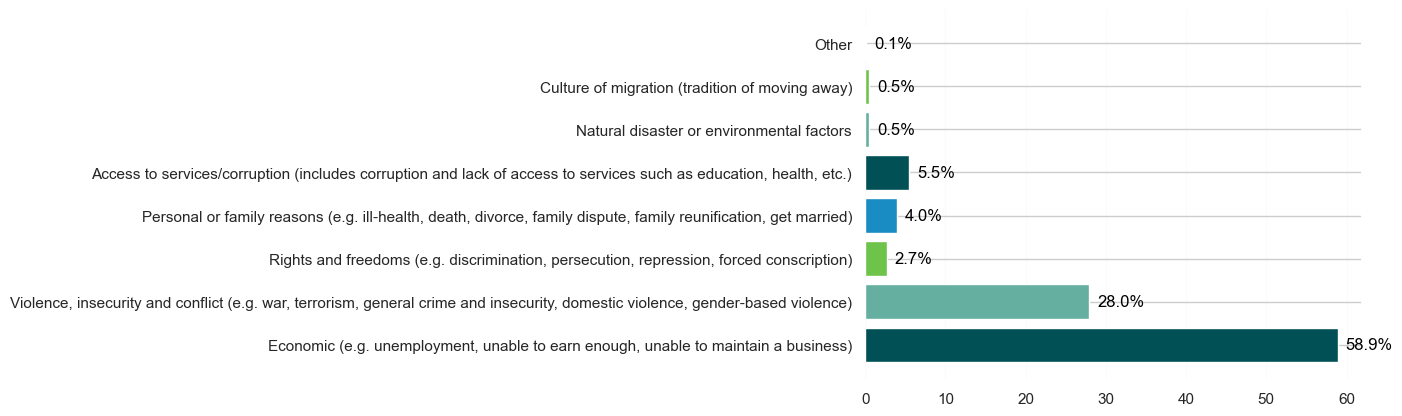

In [25]:
# Count number of non-null entries for each reason
reason_counts = {col: df[col].notna().sum() for col in cols_reasons}

# Convert to DataFrame
reason_df = pd.DataFrame(list(reason_counts.items()), columns=["Reason", "Count"])

# Optional: shorten labels for better display
reason_df["Reason"] = reason_df["Reason"].str.replace("Q78/", "", regex=False)

# Call your pre-defined bar chart function
plot_bar_chart_with_percentage(reason_df, 'Reason', 'Count', colors=colors)

### Module 5. Return Decision and Preparation
- What were the reasons you returned related to the conditions in Afghanistan?
- What were the personal reasons you returned?
- Did anyone influence your return?
- To what extent do you feel you had a choice in returning?
- How did you enter Afghanistan?

In [68]:
# What were the reasons you returned related to the conditions in Afghanistan?
r36_columns = {
    "Improved safety in Afghanistan": "R36/Improved safety in Afghanistan",
    "Improved economic opportunities in Afghanistan": "R36/Improved economic opportunities in Afghanistan",
    "Other": "R36/Other",
    "Refused": "R36/Refused",
    "Please specify": "Please specify14"
}
# Overall analysis
r36_overall = multiple_response_analysis(df, r36_columns, question_label="Reasons for Returning (R36)")

# Optional: Province-wise or Gender-wise analysis
r36_by_province = multiple_response_analysis(df, r36_columns, question_label="Reasons for Returning (R36)", group_by='R2_2')

In [69]:
r36_overall

,Reason,Frequency,Percentage
0,Reasons for Returning (R36) – Improved safety in Afghanistan,34,4.59
1,Reasons for Returning (R36) – Improved economic opportunities in Afghanistan,18,2.43
2,Reasons for Returning (R36) – Other,0,0.00
3,Reasons for Returning (R36) – Refused,6,0.81
4,Reasons for Returning (R36) – Please specify,0,0.00


In [70]:
r36_by_province

,R2_2,Improved safety in Afghanistan,Improved economic opportunities in Afghanistan,Other,Refused,Please specify
0,Germany,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
1,Iran,3 (1.09%),3 (1.09%),0 (0.0%),2 (0.72%),0 (0.0%)
2,Other country,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
3,Pakistan,30 (8.85%),14 (4.13%),0 (0.0%),2 (0.59%),0 (0.0%)
4,Pakistan,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
5,Russia,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
6,Saudi Arabia,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
7,Tajikistan,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
8,Türkiye,1 (0.97%),1 (0.97%),0 (0.0%),2 (1.94%),0 (0.0%)
9,United Kingdom,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)


In [71]:
# What were the personal reasons you returned?
r37_columns = {
    "I achieved my goals in the country of migration (e.g. enough savings, more skills, education, professional experience, family)": 
        "R37/I achieved my goals in the country of migration (e.g. enough savings, more skills, education, professional experience, family)",
    "Reunite with my family/friends in Afghanistan": "R37/Reunite with my family/friends in Afghanistan",
    "To get married": "R37/To get married",
    "Nostalgia/homesickness": "R37/Nostalgia/homesickness",
    "Other": "R37/Other",
    "Refused": "R37/Refused",
    "Please specify": "Please specify15"
}

# Overall analysis
r37_overall = multiple_response_analysis(df, r37_columns, question_label="Personal Reasons for Return (R37)")

# Grouped by Province or Gender (optional)
r37_by_province = multiple_response_analysis(df, r37_columns, question_label="Personal Reasons for Return (R37)", group_by='R2_2')

In [72]:
r37_overall

,Reason,Frequency,Percentage
0,"Personal Reasons for Return (R37) – I achieved my goals in the country of migration (e.g. enough savings, more skills, education, professional experience, family)",12,1.62
1,Personal Reasons for Return (R37) – Reunite with my family/friends in Afghanistan,52,7.03
2,Personal Reasons for Return (R37) – To get married,11,1.49
3,Personal Reasons for Return (R37) – Nostalgia/homesickness,37,5.00
4,Personal Reasons for Return (R37) – Other,0,0.00
5,Personal Reasons for Return (R37) – Refused,1,0.14
6,Personal Reasons for Return (R37) – Please specify,0,0.00


In [73]:
r37_by_province

,R2_2,"I achieved my goals in the country of migration (e.g. enough savings, more skills, education, professional experience, family)",Reunite with my family/friends in Afghanistan,To get married,Nostalgia/homesickness,Other,Refused,Please specify
0,Germany,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
1,Iran,3 (1.09%),17 (6.16%),4 (1.45%),19 (6.88%),0 (0.0%),0 (0.0%),0 (0.0%)
2,Other country,1 (9.09%),5 (45.45%),1 (9.09%),3 (27.27%),0 (0.0%),0 (0.0%),0 (0.0%)
3,Pakistan,8 (2.36%),20 (5.9%),2 (0.59%),11 (3.24%),0 (0.0%),1 (0.29%),0 (0.0%)
4,Pakistan,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
5,Russia,0 (0.0%),1 (100.0%),0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%)
6,Saudi Arabia,0 (0.0%),1 (33.33%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
7,Tajikistan,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
8,Türkiye,0 (0.0%),6 (5.83%),4 (3.88%),3 (2.91%),0 (0.0%),0 (0.0%),0 (0.0%)
9,United Kingdom,0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)


In [74]:
# Did anyone influence your return?
col_analaysis = {'Did anyone influence your return?': 'Did anyone influence your return?'}
infu_res = descriptive_analysis(df, col_analaysis)
infu_res['Did anyone influence your return?']

,Did anyone influence your return?,Frequency,Percentage
0,NaN,550,74.32
1,No,104,14.05
2,Yes,85,11.49
3,Refused,1,0.14


In [75]:
# Can you choose the biggest influences on your return?

r39_columns = {
    "Friends / family in Afghanistan": "R39/Friends / family in Afghanistan",
    "Friends / family in another country": "R39/Friends / family in another country",
    "Wider diaspora": "R39/Wider diaspora",
    "Travel agents": "R39/Travel agents",
    "Smugglers": "R39/Smugglers",
    "Private employment agency": "R39/Private employment agency",
    "Online community / network (inc social media)": "R39/Online community / network (inc social media)",
    "NGOs": "R39/NGOs",
    "International organizations (UN: IOM, UNHCR)": "R39/International organizations (UN: IOM, UNHCR)",
    "Governments / embassies of Afghanistan": "R39/Governments / embassies of Afghanistan",
    "National government / authorities in host country": "R39/National government / authorities in host country",
    "Local people in Afghanistan": "R39/Local people in Afghanistan",
    "Other migrants": "R39/Other migrants",
    "Returned migrants": "R39/Returned migrants",
    "Other": "R39/Other",
    "Don't know": "R39/Don't know",
    "Refused": "R39/Refused",
    "Please specify": "Please specify16"
}

# Overall analysis
r39_overall = multiple_response_analysis(df, r39_columns, question_label="Sources of Return Information (R39)")

# Grouped by Province or Gender (optional)
r39_by_province = multiple_response_analysis(df, r39_columns, question_label="Sources of Return Information (R39)", group_by='R2_2')

In [76]:
r39_overall

,Reason,Frequency,Percentage
0,Sources of Return Information (R39) – Friends / family in Afghanistan,74,10.00
1,Sources of Return Information (R39) – Friends / family in another country,16,2.16
2,Sources of Return Information (R39) – Wider diaspora,4,0.54
3,Sources of Return Information (R39) – Travel agents,0,0.00
4,Sources of Return Information (R39) – Smugglers,0,0.00
5,Sources of Return Information (R39) – Private employment agency,2,0.27
6,Sources of Return Information (R39) – Online community / network (inc social media),3,0.41
7,Sources of Return Information (R39) – NGOs,2,0.27
8,"Sources of Return Information (R39) – International organizations (UN: IOM, UNHCR)",2,0.27
9,Sources of Return Information (R39) – Governments / embassies of Afghanistan,2,0.27


In [77]:
r39_by_province

,R2_2,Friends / family in Afghanistan,Friends / family in another country,Wider diaspora,Travel agents,Smugglers,Private employment agency,Online community / network (inc social media),NGOs,"International organizations (UN: IOM, UNHCR)",Governments / embassies of Afghanistan,National government / authorities in host country,Local people in Afghanistan,Other migrants,Returned migrants,Other,Don't know,Refused,Please specify
0,Germany,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
1,Iran,17 (6.16%),4 (1.45%),0 (0.0%),0 (0.0%),0 (0.0%),1 (0.36%),1 (0.36%),0 (0.0%),0 (0.0%),0 (0.0%),1 (0.36%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
2,Other country,4 (36.36%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),1 (9.09%),0 (0.0%),1 (9.09%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
3,Pakistan,34 (10.03%),10 (2.95%),4 (1.18%),0 (0.0%),0 (0.0%),1 (0.29%),2 (0.59%),1 (0.29%),2 (0.59%),0 (0.0%),1 (0.29%),4 (1.18%),2 (0.59%),2 (0.59%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
4,Pakistan,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),1 (100.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
5,Russia,1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
6,Saudi Arabia,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
7,Tajikistan,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),1 (50.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
8,Türkiye,18 (17.48%),2 (1.94%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),1 (0.97%),1 (0.97%),1 (0.97%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
9,United Kingdom,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)


In [78]:
# To what extent do you feel you had a choice in returning?
choice_analysis = {'To what extent do you feel you had a choice in returning?': 'To what extent do you feel you had a choice in returning?'}
return_choice = descriptive_analysis(df, choice_analysis, group_by='R2_2')

return_choice['To what extent do you feel you had a choice in returning?']

To what extent do you feel you had a choice in returning?,"No choice: I was forced to return, there was no way I could do anything else.",Refused,Some choice,"This was completely a free choice. I did not feel coerced, intimidated, or manipulated. I had accurate and timely information, I made the decision in my own time, and there was an alternative if I did not choose to return.",Very little choice
R2_2,,,,,
Germany,0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%)
Iran,201 (72.8%),2 (0.7%),50 (18.1%),15 (5.4%),8 (2.9%)
Other country,1 (9.1%),0 (0.0%),8 (72.7%),1 (9.1%),1 (9.1%)
Pakistan,202 (59.6%),2 (0.6%),64 (18.9%),48 (14.2%),23 (6.8%)
Pakistan,1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
Russia,0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%)
Saudi Arabia,0 (0.0%),0 (0.0%),3 (100.0%),0 (0.0%),0 (0.0%)
Tajikistan,1 (50.0%),0 (0.0%),1 (50.0%),0 (0.0%),0 (0.0%)
Türkiye,65 (63.1%),0 (0.0%),12 (11.6%),22 (21.4%),4 (3.9%)


In [79]:
# How did you enter Afghanistan?
return_method = {'How did you enter Afghanistan?': 'How did you enter Afghanistan?'}

return_method_res = descriptive_analysis(df, return_method, group_by='R2_2')

return_method_res['How did you enter Afghanistan?']

How did you enter Afghanistan?,"AVR - assisted voluntary return, a formal scheme involving the government and often UN agencies","Forced return: Deportation, organized by authorities in the host country",Forced return: Expulsion,Independent / spontaneous,Refused
R2_2,,,,,
Germany,0 (0.0%),0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%)
Iran,17 (6.2%),113 (40.9%),113 (40.9%),32 (11.6%),1 (0.4%)
Other country,0 (0.0%),1 (9.1%),1 (9.1%),9 (81.8%),0 (0.0%)
Pakistan,30 (8.8%),138 (40.7%),144 (42.5%),25 (7.4%),2 (0.6%)
Pakistan,0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%)
Russia,0 (0.0%),0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%)
Saudi Arabia,0 (0.0%),0 (0.0%),1 (33.3%),2 (66.7%),0 (0.0%)
Tajikistan,0 (0.0%),0 (0.0%),1 (50.0%),1 (50.0%),0 (0.0%)
Türkiye,22 (21.4%),36 (35.0%),38 (36.9%),7 (6.8%),0 (0.0%)


In [81]:
# Did you return with family members?

return_with_family = {'Did you return with family members?': 'Did you return with family members?'}

return_family = descriptive_analysis(df, return_with_family)
return_family_province = descriptive_analysis(df, return_with_family, group_by='R2_2')

In [82]:
return_family['Did you return with family members?']

,Did you return with family members?,Frequency,Percentage
0,"Yes, we all returned",391,52.84
1,NaN,306,41.35
2,"Yes, I returned with some of my family members but some stayed",37,5.00
3,"No, they stayed in the country",5,0.68
4,Refused,1,0.14


In [83]:
return_family_province['Did you return with family members?']

Did you return with family members?,"No, they stayed in the country",Refused,"Yes, I returned with some of my family members but some stayed","Yes, we all returned",NaN
R2_2,,,,,
Germany,0 (0.0%),0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%)
Iran,4 (1.4%),0 (0.0%),7 (2.5%),122 (44.2%),143 (51.8%)
Other country,0 (0.0%),0 (0.0%),2 (18.2%),3 (27.3%),6 (54.6%)
Pakistan,1 (0.3%),1 (0.3%),23 (6.8%),249 (73.4%),65 (19.2%)
Pakistan,0 (0.0%),0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%)
Russia,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),1 (100.0%)
Saudi Arabia,0 (0.0%),0 (0.0%),2 (66.7%),0 (0.0%),1 (33.3%)
Tajikistan,0 (0.0%),0 (0.0%),0 (0.0%),1 (50.0%),1 (50.0%)
Türkiye,0 (0.0%),0 (0.0%),1 (1.0%),13 (12.6%),89 (86.4%)


In [84]:
# Why did the family not come?
r44_columns = {
    "Too vulnerable to travel (age, disability, medical needs, pregnant)": 
        "R44/Too vulnerable to travel (age, disability, medical needs, pregnant)",
    "Not enough money for them to travel": "R44/Not enough money for them to travel",
    "They did not want to return (concern/fear regarding Afghanistan)": 
        "R44/They did not want to return (concern/fear regarding Afghanistan)",
    "They were unable to return (legal/administration)": 
        "R44/They were unable to return (legal/administration)",
    "They preferred to stay in the host country and had regular status (or soon would have)": 
        "R44/They preferred to stay in the host country and had regular status (or soon would have)",
    "They preferred to stay in the host country even with irregular status": 
        "R44/They preferred to stay in the host country even with irregular status",
    "Other": "R44/Other",
    "Don't know": "R44/Don't know",
    "Refused": "R44/Refused",
    "Please specify": "Please specify18"
}

# Overall analysis
r44_overall = multiple_response_analysis(df, r44_columns, question_label="Reasons Family Members Did Not Return (R44)")

# Grouped analysis (optional)
r44_by_province = multiple_response_analysis(df, r44_columns, question_label="Reasons Family Members Did Not Return (R44)", group_by='R2_2')

In [85]:
r44_overall

,Reason,Frequency,Percentage
0,"Reasons Family Members Did Not Return (R44) – Too vulnerable to travel (age, disability, medical needs, pregnant)",1,0.14
1,Reasons Family Members Did Not Return (R44) – Not enough money for them to travel,7,0.95
2,Reasons Family Members Did Not Return (R44) – They did not want to return (concern/fear regarding Afghanistan),24,3.24
3,Reasons Family Members Did Not Return (R44) – They were unable to return (legal/administration),2,0.27
4,Reasons Family Members Did Not Return (R44) – They preferred to stay in the host country and had regular status (or soon would have),1,0.14
5,Reasons Family Members Did Not Return (R44) – They preferred to stay in the host country even with irregular status,10,1.35
6,Reasons Family Members Did Not Return (R44) – Other,0,0.00
7,Reasons Family Members Did Not Return (R44) – Don't know,0,0.00
8,Reasons Family Members Did Not Return (R44) – Refused,1,0.14
9,Reasons Family Members Did Not Return (R44) – Please specify,0,0.00


In [86]:
r44_by_province

,R2_2,"Too vulnerable to travel (age, disability, medical needs, pregnant)",Not enough money for them to travel,They did not want to return (concern/fear regarding Afghanistan),They were unable to return (legal/administration),They preferred to stay in the host country and had regular status (or soon would have),They preferred to stay in the host country even with irregular status,Other,Don't know,Refused,Please specify
0,Germany,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
1,Iran,1 (0.36%),2 (0.72%),3 (1.09%),0 (0.0%),0 (0.0%),4 (1.45%),0 (0.0%),0 (0.0%),1 (0.36%),0 (0.0%)
2,Other country,0 (0.0%),1 (9.09%),1 (9.09%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
3,Pakistan,0 (0.0%),1 (0.29%),18 (5.31%),2 (0.59%),1 (0.29%),6 (1.77%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
4,Pakistan,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
5,Russia,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
6,Saudi Arabia,0 (0.0%),0 (0.0%),2 (66.67%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
7,Tajikistan,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
8,Türkiye,0 (0.0%),1 (0.97%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
9,United Kingdom,0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)


In [87]:
# Before return, what were your sources of information about the return process - the journey, administrative process, and life after returning

r46_columns = {
    "Friends / family in Afghanistan": "R46/Friends / family in Afghanistan",
    "Friends / family in another country": "R46/Friends / family in another country",
    "Wider diaspora": "R46/Wider diaspora",
    "Travel agents": "R46/Travel agents",
    "Smugglers": "R46/Smugglers",
    "Private employment agency": "R46/Private employment agency",
    "Online community / network (inc social media)": "R46/Online community / network (inc social media)",
    "NGOs": "R46/NGOs",
    "International organizations (UN: IOM, UNHCR)": "R46/International organizations (UN: IOM, UNHCR)",
    "Governments / embassies of Afghanistan": "R46/Governments / embassies of Afghanistan",
    "National government / authorities in host country": "R46/National government / authorities in host country",
    "Local people either in Afghanistan or on the journey": "R46/Local people either in Afghanistan or on the journey",
    "Other migrants": "R46/Other migrants",
    "Returned migrants": "R46/Returned migrants",
    "Other": "R46/Other",
    "None": "R46/None",
    "Don't know": "R46/Don't know",
    "Refused": "R46/Refused",
    "Please specify": "Please specify19"
}

# Overall analysis
r46_overall = multiple_response_analysis(df, r46_columns, question_label="Support Received Before/During Return (R46)")

# Grouped analysis (optional)
r46_by_province = multiple_response_analysis(df, r46_columns, question_label="Support Received Before/During Return (R46)", group_by='R2_2')


In [88]:
r46_overall

,Reason,Frequency,Percentage
0,Support Received Before/During Return (R46) – Friends / family in Afghanistan,502,67.84
1,Support Received Before/During Return (R46) – Friends / family in another country,137,18.51
2,Support Received Before/During Return (R46) – Wider diaspora,19,2.57
3,Support Received Before/During Return (R46) – Travel agents,16,2.16
4,Support Received Before/During Return (R46) – Smugglers,1,0.14
5,Support Received Before/During Return (R46) – Private employment agency,5,0.68
6,Support Received Before/During Return (R46) – Online community / network (inc social media),31,4.19
7,Support Received Before/During Return (R46) – NGOs,8,1.08
8,"Support Received Before/During Return (R46) – International organizations (UN: IOM, UNHCR)",10,1.35
9,Support Received Before/During Return (R46) – Governments / embassies of Afghanistan,5,0.68


In [89]:
r46_by_province

,R2_2,Friends / family in Afghanistan,Friends / family in another country,Wider diaspora,Travel agents,Smugglers,Private employment agency,Online community / network (inc social media),NGOs,"International organizations (UN: IOM, UNHCR)",Governments / embassies of Afghanistan,National government / authorities in host country,Local people either in Afghanistan or on the journey,Other migrants,Returned migrants,Other,None,Don't know,Refused,Please specify
0,Germany,1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
1,Iran,201 (72.83%),33 (11.96%),0 (0.0%),2 (0.72%),1 (0.36%),3 (1.09%),4 (1.45%),1 (0.36%),1 (0.36%),0 (0.0%),26 (9.42%),7 (2.54%),25 (9.06%),36 (13.04%),0 (0.0%),0 (0.0%),3 (1.09%),0 (0.0%),0 (0.0%)
2,Other country,7 (63.64%),5 (45.45%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),1 (9.09%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
3,Pakistan,224 (66.08%),70 (20.65%),19 (5.6%),12 (3.54%),0 (0.0%),1 (0.29%),25 (7.37%),6 (1.77%),6 (1.77%),4 (1.18%),4 (1.18%),48 (14.16%),56 (16.52%),44 (12.98%),0 (0.0%),0 (0.0%),5 (1.47%),0 (0.0%),0 (0.0%)
4,Pakistan,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
5,Russia,1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
6,Saudi Arabia,1 (33.33%),2 (66.67%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
7,Tajikistan,1 (50.0%),0 (0.0%),0 (0.0%),1 (50.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),1 (50.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
8,Türkiye,65 (63.11%),25 (24.27%),0 (0.0%),1 (0.97%),0 (0.0%),1 (0.97%),2 (1.94%),1 (0.97%),3 (2.91%),0 (0.0%),17 (16.5%),4 (3.88%),22 (21.36%),31 (30.1%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
9,United Kingdom,0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)


In [25]:
# How well informed do you feel you were about the return journey and life after return?
life_after_return = {'How well informed do you feel you were about the return journey and life after return?': 'How well informed do you feel you were about the return journey and life after return?'}

life_after_return_res = descriptive_analysis(df, life_after_return)

life_after_return_res['How well informed do you feel you were about the return journey and life after return?']

,How well informed do you feel you were about the return journey and life after return?,Frequency,Percentage
0,Somewhat informed,230,31.08
1,Well informed,226,30.54
2,Slightly informed,165,22.30
3,Not informed at all,82,11.08
4,Fully informed,24,3.24
5,Don't know,13,1.76


In [91]:
# Did you receive any assistance in the period just before departing from ${R2_2}${R2_1}?
assistance_recieved = {'Did you receive any assistance in the period just before departing from ${R2_2}${R2_1}?': 'Did you receive any assistance in the period just before departing from ${R2_2}${R2_1}?'}

assistance_recieved_res = descriptive_analysis(df, assistance_recieved)

assistance_recieved_res['Did you receive any assistance in the period just before departing from ${R2_2}${R2_1}?']

,Did you receive any assistance in the period just before departing from ${R2_2}${R2_1}?,Frequency,Percentage
0,No,552,74.59
1,Yes,188,25.41


In [92]:
# What kind of assistance did you receive?

r49_columns = {
    "Shelter": "R49/Shelter",
    "Medical assistance": "R49/Medical assistance",
    "Psychological support": "R49/Psychological support",
    "Legal assistance": "R49/Legal assistance",
    "Food": "R49/Food",
    "Water": "R49/Water",
    "Clothes / shoes / blankets / sleeping bags": "R49/Clothes / shoes / blankets / sleeping bags",
    "Washing / bathroom facilities": "R49/Washing / bathroom facilities",
    "Access to communication (phone / internet)": "R49/Access to communication (phone / internet)",
    "Cash": "R49/Cash",
    "Safe spaces (for women and children)": "R49/Safe spaces (for women and children)",
    "Spiritual guidance": "R49/Spiritual guidance",
    "Other": "R49/Other",
    "Refused": "R49/Refused",
    "Please specify": "Please specify20"
}

# R49 – Type of Assistance
r49_overall = multiple_response_analysis(df, r49_columns, question_label="Type of Assistance Received (R49)")

r49_by_province = multiple_response_analysis(df, r49_columns, question_label="Type of Assistance Received (R49)", group_by='R2_2')

In [93]:
r49_overall

,Reason,Frequency,Percentage
0,Type of Assistance Received (R49) – Shelter,6,0.81
1,Type of Assistance Received (R49) – Medical assistance,13,1.76
2,Type of Assistance Received (R49) – Psychological support,0,0.00
3,Type of Assistance Received (R49) – Legal assistance,2,0.27
4,Type of Assistance Received (R49) – Food,54,7.30
5,Type of Assistance Received (R49) – Water,42,5.68
6,Type of Assistance Received (R49) – Clothes / shoes / blankets / sleeping bags,74,10.00
7,Type of Assistance Received (R49) – Washing / bathroom facilities,68,9.19
8,Type of Assistance Received (R49) – Access to communication (phone / internet),6,0.81
9,Type of Assistance Received (R49) – Cash,162,21.89


In [94]:
r49_by_province

,R2_2,Shelter,Medical assistance,Psychological support,Legal assistance,Food,Water,Clothes / shoes / blankets / sleeping bags,Washing / bathroom facilities,Access to communication (phone / internet),Cash,Safe spaces (for women and children),Spiritual guidance,Other,Refused,Please specify
0,Germany,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
1,Iran,1 (0.36%),3 (1.09%),0 (0.0%),2 (0.72%),21 (7.61%),17 (6.16%),37 (13.41%),23 (8.33%),0 (0.0%),62 (22.46%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
2,Other country,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
3,Pakistan,4 (1.18%),9 (2.65%),0 (0.0%),0 (0.0%),31 (9.14%),23 (6.78%),35 (10.32%),42 (12.39%),6 (1.77%),94 (27.73%),2 (0.59%),1 (0.29%),0 (0.0%),0 (0.0%),0 (0.0%)
4,Pakistan,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
5,Russia,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
6,Saudi Arabia,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
7,Tajikistan,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
8,Türkiye,1 (0.97%),1 (0.97%),0 (0.0%),0 (0.0%),2 (1.94%),2 (1.94%),2 (1.94%),3 (2.91%),0 (0.0%),6 (5.83%),0 (0.0%),1 (0.97%),0 (0.0%),0 (0.0%),0 (0.0%)
9,United Kingdom,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)


In [95]:
# R50 – Who Provided the Assistance
r50_columns = {
    "The government of the host country": "R50/The government of the host country",
    "UN as part of AVR (for example IOM)": "R50/UN as part of AVR (for example IOM)",
    "UN (other than AVR)": "R50/UN (other than AVR)",
    "NGOs as part of AVR": "R50/NGOs as part of AVR",
    "NGOs (other than AVR)": "R50/NGOs (other than AVR)",
    "Local population / volunteers": "R50/Local population / volunteers",
    "Fellow migrants": "R50/Fellow migrants",
    "Family / friends": "R50/Family / friends",
    "Smugglers": "R50/Smugglers",
    "Other": "R50/Other",
    "Don't know": "R50/Don't know",
    "Refused": "R50/Refused",
    "Please specify": "Please specify21"
}

# R50 – Provider of Assistance
r50_overall = multiple_response_analysis(df, r50_columns, question_label="Provider of Assistance (R50)")

r50_by_province = multiple_response_analysis(df, r50_columns, question_label="Provider of Assistance (R50)", group_by='R2_2')

In [96]:
r50_overall

,Reason,Frequency,Percentage
0,Provider of Assistance (R50) – The government of the host country,7,0.95
1,Provider of Assistance (R50) – UN as part of AVR (for example IOM),130,17.57
2,Provider of Assistance (R50) – UN (other than AVR),19,2.57
3,Provider of Assistance (R50) – NGOs as part of AVR,18,2.43
4,Provider of Assistance (R50) – NGOs (other than AVR),17,2.30
5,Provider of Assistance (R50) – Local population / volunteers,1,0.14
6,Provider of Assistance (R50) – Fellow migrants,0,0.00
7,Provider of Assistance (R50) – Family / friends,1,0.14
8,Provider of Assistance (R50) – Smugglers,0,0.00
9,Provider of Assistance (R50) – Other,0,0.00


In [97]:
r50_by_province

,R2_2,The government of the host country,UN as part of AVR (for example IOM),UN (other than AVR),NGOs as part of AVR,NGOs (other than AVR),Local population / volunteers,Fellow migrants,Family / friends,Smugglers,Other,Don't know,Refused,Please specify
0,Germany,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
1,Iran,0 (0.0%),58 (21.01%),12 (4.35%),12 (4.35%),5 (1.81%),1 (0.36%),0 (0.0%),1 (0.36%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
2,Other country,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
3,Pakistan,5 (1.47%),66 (19.47%),5 (1.47%),4 (1.18%),11 (3.24%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),30 (8.85%),0 (0.0%),0 (0.0%)
4,Pakistan,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
5,Russia,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
6,Saudi Arabia,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
7,Tajikistan,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
8,Türkiye,2 (1.94%),6 (5.83%),2 (1.94%),2 (1.94%),1 (0.97%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
9,United Kingdom,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)


In [99]:
# Before you left on your return journey, to what extent did you feel prepared to return?
prepared_return_analysis = {'Before you left on your return journey, to what extent did you feel prepared to return?': 'Before you left on your return journey, to what extent did you feel prepared to return?'}

prepared_return_res = descriptive_analysis(df, prepared_return_analysis)
prepared_return_res_country = descriptive_analysis(df, prepared_return_analysis, group_by='R2_2')

In [100]:
prepared_return_res['Before you left on your return journey, to what extent did you feel prepared to return?']

,"Before you left on your return journey, to what extent did you feel prepared to return?",Frequency,Percentage
0,Not prepared at all,292,39.46
1,Somewhat prepared,192,25.95
2,Only slightly prepared,128,17.30
3,Well prepared,110,14.86
4,Fully prepared,13,1.76
5,Don't know,5,0.68


In [101]:
prepared_return_res_country['Before you left on your return journey, to what extent did you feel prepared to return?']

"Before you left on your return journey, to what extent did you feel prepared to return?",Don't know,Fully prepared,Not prepared at all,Only slightly prepared,Somewhat prepared,Well prepared
R2_2,,,,,,
Germany,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),1 (100.0%)
Iran,2 (0.7%),7 (2.5%),120 (43.5%),43 (15.6%),86 (31.2%),18 (6.5%)
Other country,0 (0.0%),0 (0.0%),1 (9.1%),0 (0.0%),5 (45.4%),5 (45.4%)
Pakistan,2 (0.6%),6 (1.8%),129 (38.0%),61 (18.0%),64 (18.9%),77 (22.7%)
Pakistan,0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%)
Russia,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%)
Saudi Arabia,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),2 (66.7%),1 (33.3%)
Tajikistan,0 (0.0%),0 (0.0%),0 (0.0%),2 (100.0%),0 (0.0%),0 (0.0%)
Türkiye,1 (1.0%),0 (0.0%),40 (38.8%),22 (21.4%),32 (31.1%),8 (7.8%)


In [102]:
# How did you prepare for your return?

r55_columns = {
    "Assistance: pre-departure counselling on return options and practicalities":
        "R55/Assistance: pre-departure counselling on return options and practicalities",
    "Assistance: conditional cash": "R55/Assistance: conditional cash",
    "Assistance: unconditional cash": "R55/Assistance: unconditional cash",
    "Assistance: vocational training": "R55/Assistance: vocational training",
    "Assistance: contact with family": "R55/Assistance: contact with family",
    "Saving money for return": "R55/Saving money for return",
    "Gathering information on conditions in Afghanistan": "R55/Gathering information on conditions in Afghanistan",
    "Gathering information on return journey": "R55/Gathering information on return journey",
    "Organising job/accommodation in Afghanistan": "R55/Organising job/accommodation in Afghanistan",
    "Nothing": "R55/Nothing",
    "Other": "R55/Other",
    "Refused": "R55/Refused",
    "Please specify": "Please specify22"
}

# Overall analysis
r55_overall = multiple_response_analysis(df, r55_columns, question_label="Preparations Before Return (R55)")

# Grouped analysis (optional)
r55_by_province = multiple_response_analysis(df, r55_columns, question_label="Preparations Before Return (R55)", group_by='R2_2')

In [103]:
r55_overall

,Reason,Frequency,Percentage
0,Preparations Before Return (R55) – Assistance: pre-departure counselling on return options and practicalities,96,12.97
1,Preparations Before Return (R55) – Assistance: conditional cash,103,13.92
2,Preparations Before Return (R55) – Assistance: unconditional cash,18,2.43
3,Preparations Before Return (R55) – Assistance: vocational training,21,2.84
4,Preparations Before Return (R55) – Assistance: contact with family,150,20.27
5,Preparations Before Return (R55) – Saving money for return,161,21.76
6,Preparations Before Return (R55) – Gathering information on conditions in Afghanistan,142,19.19
7,Preparations Before Return (R55) – Gathering information on return journey,124,16.76
8,Preparations Before Return (R55) – Organising job/accommodation in Afghanistan,52,7.03
9,Preparations Before Return (R55) – Nothing,37,5.00


In [104]:
r55_by_province

,R2_2,Assistance: pre-departure counselling on return options and practicalities,Assistance: conditional cash,Assistance: unconditional cash,Assistance: vocational training,Assistance: contact with family,Saving money for return,Gathering information on conditions in Afghanistan,Gathering information on return journey,Organising job/accommodation in Afghanistan,Nothing,Other,Refused,Please specify
0,Germany,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
1,Iran,11 (3.99%),29 (10.51%),2 (0.72%),12 (4.35%),58 (21.01%),48 (17.39%),28 (10.14%),17 (6.16%),3 (1.09%),17 (6.16%),0 (0.0%),1 (0.36%),0 (0.0%)
2,Other country,4 (36.36%),2 (18.18%),0 (0.0%),0 (0.0%),1 (9.09%),3 (27.27%),5 (45.45%),3 (27.27%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
3,Pakistan,63 (18.58%),55 (16.22%),11 (3.24%),3 (0.88%),64 (18.88%),86 (25.37%),91 (26.84%),88 (25.96%),36 (10.62%),15 (4.42%),0 (0.0%),0 (0.0%),0 (0.0%)
4,Pakistan,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
5,Russia,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
6,Saudi Arabia,0 (0.0%),1 (33.33%),0 (0.0%),0 (0.0%),0 (0.0%),2 (66.67%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
7,Tajikistan,1 (50.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),1 (50.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
8,Türkiye,17 (16.5%),14 (13.59%),5 (4.85%),6 (5.83%),27 (26.21%),21 (20.39%),17 (16.5%),16 (15.53%),12 (11.65%),5 (4.85%),0 (0.0%),0 (0.0%),0 (0.0%)
9,United Kingdom,0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)


In [105]:
# What would have made you better prepared to return?
r56_columns = {
    "Better information about security, risks and dangers on the return journey":
        "R56/Better information about security, risks and dangers on the return journey",
    "Better information about security situation in Afghanistan":
        "R56/Better information about security situation in Afghanistan",
    "Better information about economic opportunities in Afghanistan":
        "R56/Better information about economic opportunities in Afghanistan",
    "Better plan my arrival beforehand (job, accommodation, etc.)":
        "R56/Better plan my arrival beforehand (job, accommodation, etc.)",
    "Better organization of the return journey":
        "R56/Better organization of the return journey",
    "Contact with family and friends": "R56/Contact with family and friends",
    "Cash assistance for returnees": "R56/Cash assistance for returnees",
    "Nothing more was needed": "R56/Nothing more was needed",
    "Other": "R56/Other",
    "Don't know": "R56/Don't know",
    "Refused": "R56/Refused",
    "Please specify": "Please specify23"
}

# Overall analysis
r56_overall = multiple_response_analysis(df, r56_columns, question_label="What Could Have Helped Returnees (R56)")

# Optional: Grouped analysis
r56_by_province = multiple_response_analysis(df, r56_columns, question_label="What Could Have Helped Returnees (R56)", group_by='R2_2')

In [106]:
r56_overall

,Reason,Frequency,Percentage
0,"What Could Have Helped Returnees (R56) – Better information about security, risks and dangers on the return journey",231,31.22
1,What Could Have Helped Returnees (R56) – Better information about security situation in Afghanistan,389,52.57
2,What Could Have Helped Returnees (R56) – Better information about economic opportunities in Afghanistan,271,36.62
3,"What Could Have Helped Returnees (R56) – Better plan my arrival beforehand (job, accommodation, etc.)",190,25.68
4,What Could Have Helped Returnees (R56) – Better organization of the return journey,118,15.95
5,What Could Have Helped Returnees (R56) – Contact with family and friends,212,28.65
6,What Could Have Helped Returnees (R56) – Cash assistance for returnees,219,29.59
7,What Could Have Helped Returnees (R56) – Nothing more was needed,13,1.76
8,What Could Have Helped Returnees (R56) – Other,0,0.00
9,What Could Have Helped Returnees (R56) – Don't know,24,3.24


In [107]:
r56_by_province

,R2_2,"Better information about security, risks and dangers on the return journey",Better information about security situation in Afghanistan,Better information about economic opportunities in Afghanistan,"Better plan my arrival beforehand (job, accommodation, etc.)",Better organization of the return journey,Contact with family and friends,Cash assistance for returnees,Nothing more was needed,Other,Don't know,Refused,Please specify
0,Germany,0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
1,Iran,52 (18.84%),94 (34.06%),84 (30.43%),39 (14.13%),23 (8.33%),70 (25.36%),71 (25.72%),9 (3.26%),0 (0.0%),12 (4.35%),0 (0.0%),0 (0.0%)
2,Other country,0 (0.0%),7 (63.64%),7 (63.64%),3 (27.27%),1 (9.09%),0 (0.0%),2 (18.18%),1 (9.09%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
3,Pakistan,144 (42.48%),244 (71.98%),147 (43.36%),128 (37.76%),88 (25.96%),102 (30.09%),124 (36.58%),2 (0.59%),0 (0.0%),2 (0.59%),0 (0.0%),0 (0.0%)
4,Pakistan,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
5,Russia,0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
6,Saudi Arabia,2 (66.67%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),1 (33.33%),0 (0.0%),0 (0.0%)
7,Tajikistan,0 (0.0%),0 (0.0%),0 (0.0%),1 (50.0%),0 (0.0%),1 (50.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
8,Türkiye,33 (32.04%),41 (39.81%),32 (31.07%),19 (18.45%),6 (5.83%),38 (36.89%),21 (20.39%),1 (0.97%),0 (0.0%),9 (8.74%),0 (0.0%),0 (0.0%)
9,United Kingdom,0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)


### Module 6: Return Journey Experience
- Experiences, safety measures, and abuses encountered during the return journey.

In [108]:
# How did you travel to Afghanistan?
travel_to_afghanistan_method = {'How did you travel to Afghanistan?': 'How did you travel to Afghanistan?'}

travel_to_afghanistan_method_res = descriptive_analysis(df, travel_to_afghanistan_method)
travel_to_afghanistan_method_res_country = descriptive_analysis(df, travel_to_afghanistan_method, group_by='R2_2')

In [109]:
travel_to_afghanistan_method_res['How did you travel to Afghanistan?']

,How did you travel to Afghanistan?,Frequency,Percentage
0,By land/sea,640,86.49
1,"By airplane, directly from the country of migration",71,9.59
2,By airplane and land/sea,25,3.38
3,Refused,3,0.41
4,By land,1,0.14


In [110]:
travel_to_afghanistan_method_res_country['How did you travel to Afghanistan?']

How did you travel to Afghanistan?,By airplane and land/sea,"By airplane, directly from the country of migration",By land,By land/sea,Refused
R2_2,,,,,
Germany,0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%)
Iran,3 (1.1%),1 (0.4%),0 (0.0%),269 (97.5%),3 (1.1%)
Other country,0 (0.0%),7 (63.6%),0 (0.0%),4 (36.4%),0 (0.0%)
Pakistan,0 (0.0%),0 (0.0%),1 (0.3%),338 (99.7%),0 (0.0%)
Pakistan,0 (0.0%),0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%)
Russia,0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%)
Saudi Arabia,0 (0.0%),3 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%)
Tajikistan,0 (0.0%),1 (50.0%),0 (0.0%),1 (50.0%),0 (0.0%)
Türkiye,22 (21.4%),56 (54.4%),0 (0.0%),25 (24.3%),0 (0.0%)


In [112]:
# Did you spend more than one month in any other country on your way back from ${R2_2}${R2_1}?

spend_more_month_analysis = {'Did you spend more than one month in any other country on your way back from ${R2_2}${R2_1}?': 'Did you spend more than one month in any other country on your way back from ${R2_2}${R2_1}?'}

spend_more_month_analysis_res = descriptive_analysis(df, spend_more_month_analysis)

spend_more_month_analysis_res['Did you spend more than one month in any other country on your way back from ${R2_2}${R2_1}?']

,Did you spend more than one month in any other country on your way back from ${R2_2}${R2_1}?,Frequency,Percentage
0,No,655,88.51
1,NaN,71,9.59
2,Yes,14,1.89


In [122]:
# Did any of the following happen to you during your return journey?
r59_columns = {
    "Pushback at a border": "R59/Pushback at a border",
    "Expulsion": "R59/Expulsion",
    "None": "R59/None",
    "Other": "R59/Other",
    "Refused": "R59/Refused",
    "Please specify": "Please specify25"
}

# R59
r59_overall = multiple_response_analysis(df, r59_columns, question_label="Return Trip Experience – Final Deportation (R59)")

r59_by_country = multiple_response_analysis(df, r59_columns, question_label="Return Trip Experience – Final Deportation (R59)", group_by='R2_2')


In [118]:
r59_overall

,Reason,Frequency,Percentage
0,Return Trip Experience – Final Deportation (R59) – Pushback at a border,6,0.81
1,Return Trip Experience – Final Deportation (R59) – Expulsion,4,0.54
2,Return Trip Experience – Final Deportation (R59) – None,0,0.00
3,Return Trip Experience – Final Deportation (R59) – Other,0,0.00
4,Return Trip Experience – Final Deportation (R59) – Refused,1,0.14
5,Return Trip Experience – Final Deportation (R59) – Please specify,0,0.00


In [119]:
r59_2_overall

,Reason,Frequency,Percentage
0,Return Trip Experience – Additional (R59_2) – Pushback at a border,104,14.05
1,Return Trip Experience – Additional (R59_2) – Expulsion,296,40.00
2,Return Trip Experience – Additional (R59_2) – None,0,0.00
3,Return Trip Experience – Additional (R59_2) – Other,0,0.00
4,Return Trip Experience – Additional (R59_2) – Refused,10,1.35
5,Return Trip Experience – Additional (R59_2) – Please specify,0,0.00


In [123]:
# Apart from your final deportation to Afghanistan, did any of the following happen to you during your return trip?
r59_2_columns = {
    "Pushback at a border": "R59_2/Pushback at a border",
    "Expulsion": "R59_2/Expulsion",
    "None": "R59_2/None",
    "Other": "R59_2/Other",
    "Refused": "R59_2/Refused",
    "Please specify": "Please specify26"
}

# R59_2
r59_2_overall = multiple_response_analysis(df, r59_2_columns, question_label="Return Trip Experience – Additional (R59_2)")
r59_2_by_country = multiple_response_analysis(df, r59_2_columns, question_label="Return Trip Experience – Additional (R59_2)", group_by='R2_2')

In [124]:
r59_by_country

,R2_2,Pushback at a border,Expulsion,None,Other,Refused,Please specify
0,Germany,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
1,Iran,1 (0.36%),2 (0.72%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
2,Other country,0 (0.0%),2 (18.18%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
3,Pakistan,5 (1.47%),0 (0.0%),0 (0.0%),0 (0.0%),1 (0.29%),0 (0.0%)
4,Pakistan,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
5,Russia,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
6,Saudi Arabia,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
7,Tajikistan,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
8,Türkiye,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
9,United Kingdom,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)


In [125]:
r59_2_by_country

,R2_2,Pushback at a border,Expulsion,None,Other,Refused,Please specify
0,Germany,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
1,Iran,8 (2.9%),121 (43.84%),0 (0.0%),0 (0.0%),1 (0.36%),0 (0.0%)
2,Other country,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
3,Pakistan,88 (25.96%),138 (40.71%),0 (0.0%),0 (0.0%),8 (2.36%),0 (0.0%)
4,Pakistan,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
5,Russia,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
6,Saudi Arabia,0 (0.0%),1 (33.33%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
7,Tajikistan,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
8,Türkiye,7 (6.8%),36 (34.95%),0 (0.0%),0 (0.0%),1 (0.97%),0 (0.0%)
9,United Kingdom,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)


In [127]:
# To what extent do you agree with this statement: "I (and my family, if applicable) felt safe and secure during the return journey"
agree_disagree_analysis = {'To what extent do you agree with this statement: "I (and my family, if applicable) felt safe and secure during the return journey"': 'To what extent do you agree with this statement: "I (and my family, if applicable) felt safe and secure during the return journey"'}

agree_disagree_analysis_res = descriptive_analysis(df, agree_disagree_analysis)

agree_disagree_analysis_res['To what extent do you agree with this statement: "I (and my family, if applicable) felt safe and secure during the return journey"']

,"To what extent do you agree with this statement: ""I (and my family, if applicable) felt safe and secure during the return journey""",Frequency,Percentage
0,Agree (I/we felt somewhat safe),383,51.76
1,Completely agree (I/we felt very safe),180,24.32
2,Neither agree nor disagree (I/we felt neither safe nor unsafe),96,12.97
3,Disagree (I didn't/we didn't feel too safe),55,7.43
4,Strongly disagree (I didn't feel / we really felt unsafe),18,2.43
5,Refused,8,1.08


In [128]:
# What did you do to protect yourself from abuse and crime on your return journey?
r62_columns = {
    "Travel alone": "R62/Travel alone",
    "Travel in a group": "R62/Travel in a group",
    "Carry cash": "R62/Carry cash",
    "Avoid carrying cash": "R62/Avoid carrying cash",
    "Keep in regular contact with family": "R62/Keep in regular contact with family",
    "Look for information and follow recommendations": "R62/Look for information and follow recommendations",
    "Stop in places with trusted contacts": "R62/Stop in places with trusted contacts",
    "Avoid large cities": "R62/Avoid large cities",
    "Plan my journey carefully": "R62/Plan my journey carefully",
    "Other": "R62/Other",
    "Nothing": "R62/Nothing",
    "Refused": "R62/Refused",
    "Please specify": "Please specify27"
}

# Overall analysis
r62_overall = multiple_response_analysis(df, r62_columns, question_label="Safe Travel Strategies Taken (R62)")

# Optional: Grouped analysis
r62_by_province = multiple_response_analysis(df, r62_columns, question_label="Safe Travel Strategies Taken (R62)", group_by='R2_2')

In [129]:
r62_overall

,Reason,Frequency,Percentage
0,Safe Travel Strategies Taken (R62) – Travel alone,46,6.22
1,Safe Travel Strategies Taken (R62) – Travel in a group,194,26.22
2,Safe Travel Strategies Taken (R62) – Carry cash,49,6.62
3,Safe Travel Strategies Taken (R62) – Avoid carrying cash,68,9.19
4,Safe Travel Strategies Taken (R62) – Keep in regular contact with family,201,27.16
5,Safe Travel Strategies Taken (R62) – Look for information and follow recommendations,165,22.30
6,Safe Travel Strategies Taken (R62) – Stop in places with trusted contacts,170,22.97
7,Safe Travel Strategies Taken (R62) – Avoid large cities,55,7.43
8,Safe Travel Strategies Taken (R62) – Plan my journey carefully,132,17.84
9,Safe Travel Strategies Taken (R62) – Other,0,0.00


In [130]:
r62_by_province

,R2_2,Travel alone,Travel in a group,Carry cash,Avoid carrying cash,Keep in regular contact with family,Look for information and follow recommendations,Stop in places with trusted contacts,Avoid large cities,Plan my journey carefully,Other,Nothing,Refused,Please specify
0,Germany,0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
1,Iran,11 (3.99%),52 (18.84%),17 (6.16%),26 (9.42%),66 (23.91%),52 (18.84%),48 (17.39%),5 (1.81%),16 (5.8%),0 (0.0%),102 (36.96%),2 (0.72%),0 (0.0%)
2,Other country,0 (0.0%),1 (9.09%),2 (18.18%),3 (27.27%),1 (9.09%),1 (9.09%),1 (9.09%),0 (0.0%),1 (9.09%),0 (0.0%),2 (18.18%),0 (0.0%),0 (0.0%)
3,Pakistan,24 (7.08%),131 (38.64%),21 (6.19%),27 (7.96%),100 (29.5%),90 (26.55%),97 (28.61%),39 (11.5%),76 (22.42%),0 (0.0%),57 (16.81%),4 (1.18%),0 (0.0%)
4,Pakistan,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%)
5,Russia,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%)
6,Saudi Arabia,0 (0.0%),0 (0.0%),1 (33.33%),2 (66.67%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
7,Tajikistan,0 (0.0%),0 (0.0%),1 (50.0%),0 (0.0%),1 (50.0%),2 (100.0%),0 (0.0%),0 (0.0%),1 (50.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
8,Türkiye,11 (10.68%),10 (9.71%),6 (5.83%),9 (8.74%),33 (32.04%),20 (19.42%),23 (22.33%),11 (10.68%),38 (36.89%),0 (0.0%),33 (32.04%),0 (0.0%),0 (0.0%)
9,United Kingdom,0 (0.0%),0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)


In [131]:
# Did you (or your family) experience any human rights violations or protection incidents on your return journey? Remember, you have the right not to answer and we can move on.
r63_columns = {
    "No": "R63/No",
    "Witnessed death": "R63/Witnessed death",
    "Physical violence": "R63/Physical violence",
    "Sexual violence": "R63/Sexual violence",
    "Robbery": "R63/Robbery",
    "Detention by authorities": "R63/Detention by authorities",
    "Kidnapping": "R63/Kidnapping",
    "Bribery/extortion": "R63/Bribery/extortion",
    "Non-physical violence (e.g. harassment, stigma, xenophobia)": 
        "R63/Non-physical violence (e.g. harassment, stigma, xenophobia)",
    "Harm from harsh conditions (e.g. exposure to extreme weather conditions, deprivation of water, deprivation of food, deprivation of health care, etc)": 
        "R63/Harm from harsh conditions (e.g. exposure to extreme weather conditions, deprivation of water, deprivation of food, deprivation of health care, etc)",
    "Other": "R63/Other",
    "Refused": "R63/Refused",
    "Please specify": "Please specify28"
}

# Overall analysis
r63_overall = multiple_response_analysis(df, r63_columns, question_label="Dangers Experienced During Return (R63)")

# Optional: Grouped analysis
r63_by_province = multiple_response_analysis(df, r63_columns, question_label="Dangers Experienced During Return (R63)", group_by='R2_2')


In [132]:
r63_overall

,Reason,Frequency,Percentage
0,Dangers Experienced During Return (R63) – No,294,39.73
1,Dangers Experienced During Return (R63) – Witnessed death,9,1.22
2,Dangers Experienced During Return (R63) – Physical violence,26,3.51
3,Dangers Experienced During Return (R63) – Sexual violence,1,0.14
4,Dangers Experienced During Return (R63) – Robbery,4,0.54
5,Dangers Experienced During Return (R63) – Detention by authorities,9,1.22
6,Dangers Experienced During Return (R63) – Kidnapping,3,0.41
7,Dangers Experienced During Return (R63) – Bribery/extortion,18,2.43
8,"Dangers Experienced During Return (R63) – Non-physical violence (e.g. harassment, stigma, xenophobia)",21,2.84
9,"Dangers Experienced During Return (R63) – Harm from harsh conditions (e.g. exposure to extreme weather conditions, deprivation of water, deprivation of food, deprivation of health care, etc)",6,0.81


In [133]:
r63_by_province

,R2_2,No,Witnessed death,Physical violence,Sexual violence,Robbery,Detention by authorities,Kidnapping,Bribery/extortion,"Non-physical violence (e.g. harassment, stigma, xenophobia)","Harm from harsh conditions (e.g. exposure to extreme weather conditions, deprivation of water, deprivation of food, deprivation of health care, etc)",Other,Refused,Please specify
0,Germany,1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
1,Iran,112 (40.58%),5 (1.81%),17 (6.16%),1 (0.36%),2 (0.72%),3 (1.09%),2 (0.72%),13 (4.71%),10 (3.62%),3 (1.09%),0 (0.0%),6 (2.17%),0 (0.0%)
2,Other country,9 (81.82%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
3,Pakistan,113 (33.33%),0 (0.0%),3 (0.88%),0 (0.0%),2 (0.59%),3 (0.88%),0 (0.0%),5 (1.47%),9 (2.65%),1 (0.29%),0 (0.0%),5 (1.47%),0 (0.0%)
4,Pakistan,0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
5,Russia,1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
6,Saudi Arabia,2 (66.67%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
7,Tajikistan,2 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
8,Türkiye,52 (50.49%),4 (3.88%),5 (4.85%),0 (0.0%),0 (0.0%),2 (1.94%),1 (0.97%),0 (0.0%),2 (1.94%),2 (1.94%),0 (0.0%),2 (1.94%),0 (0.0%)
9,United Kingdom,1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)


In [134]:
# Who were the perpetrators?

r64_columns = {
    "Smugglers": "R64/Smugglers",
    "Criminal gangs": "R64/Criminal gangs",
    "Armed groups / militias": "R64/Armed groups / militias",
    "Border guards/immigration officials": "R64/Border guards/immigration officials",
    "Military / police": "R64/Military / police",
    "Organizations organizing the return processes (UN, NGOs,etc)": 
        "R64/Organizations organizing the return processes (UN, NGOs,etc)",
    "Other returnees": "R64/Other returnees",
    "Family members": "R64/Family members",
    "People from local community": "R64/People from local community",
    "None": "R64/None",
    "Other": "R64/Other",
    "Don't know": "R64/Don't know",
    "Refused": "R64/Refused",
    "Please specify": "Please specify29"
}

# Overall analysis
r64_overall = multiple_response_analysis(df, r64_columns, question_label="Who Caused the Dangers (R64)")

# Optional: Grouped analysis
r64_by_province = multiple_response_analysis(df, r64_columns, question_label="Who Caused the Dangers (R64)", group_by='R2_2')

In [135]:
r64_overall

,Reason,Frequency,Percentage
0,Who Caused the Dangers (R64) – Smugglers,10,1.35
1,Who Caused the Dangers (R64) – Criminal gangs,5,0.68
2,Who Caused the Dangers (R64) – Armed groups / militias,6,0.81
3,Who Caused the Dangers (R64) – Border guards/immigration officials,18,2.43
4,Who Caused the Dangers (R64) – Military / police,33,4.46
5,"Who Caused the Dangers (R64) – Organizations organizing the return processes (UN, NGOs,etc)",0,0.00
6,Who Caused the Dangers (R64) – Other returnees,1,0.14
7,Who Caused the Dangers (R64) – Family members,1,0.14
8,Who Caused the Dangers (R64) – People from local community,2,0.27
9,Who Caused the Dangers (R64) – None,0,0.00


In [136]:
r64_by_province

,R2_2,Smugglers,Criminal gangs,Armed groups / militias,Border guards/immigration officials,Military / police,"Organizations organizing the return processes (UN, NGOs,etc)",Other returnees,Family members,People from local community,None,Other,Don't know,Refused,Please specify
0,Germany,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
1,Iran,6 (2.17%),4 (1.45%),3 (1.09%),10 (3.62%),23 (8.33%),0 (0.0%),0 (0.0%),0 (0.0%),1 (0.36%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
2,Other country,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
3,Pakistan,0 (0.0%),0 (0.0%),3 (0.88%),7 (2.06%),7 (2.06%),0 (0.0%),1 (0.29%),0 (0.0%),1 (0.29%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
4,Pakistan,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
5,Russia,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
6,Saudi Arabia,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
7,Tajikistan,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
8,Türkiye,4 (3.88%),1 (0.97%),0 (0.0%),1 (0.97%),2 (1.94%),0 (0.0%),0 (0.0%),1 (0.97%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
9,United Kingdom,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)


#### Module 7: Post-Return Reintegration
- Economic and social integration upon returning, employment status, and income challenges.

In [13]:
# Where did you go upon your arrival?

arrival_analysis= {'Where did you go upon your arrival?': 'Where did you go upon your arrival?'}

arrival_analysis_res = descriptive_analysis(df, arrival_analysis)
arrival_analysis_res_country = descriptive_analysis(df, arrival_analysis, group_by='R2_2')

In [14]:
arrival_analysis_res['Where did you go upon your arrival?']

,Where did you go upon your arrival?,Frequency,Percentage
0,Directly to my province of origin/previous province of residence,523,70.68
1,"I went somewhere I'd stayed before, but not my place of origin",166,22.43
2,I went somewhere completely new,47,6.35
3,"Nowhere, I stayed where I 'landed'",3,0.41
4,Refused,1,0.14


In [15]:
arrival_analysis_res_country['Where did you go upon your arrival?']

Where did you go upon your arrival?,Directly to my province of origin/previous province of residence,"I went somewhere I'd stayed before, but not my place of origin",I went somewhere completely new,"Nowhere, I stayed where I 'landed'",Refused
R2_2,,,,,
Germany,0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%)
Iran,220 (79.7%),52 (18.8%),4 (1.4%),0 (0.0%),0 (0.0%)
Other country,7 (63.6%),1 (9.1%),3 (27.3%),0 (0.0%),0 (0.0%)
Pakistan,196 (57.8%),103 (30.4%),38 (11.2%),1 (0.3%),1 (0.3%)
Pakistan,0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%)
Russia,1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
Saudi Arabia,3 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
Tajikistan,2 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
Türkiye,92 (89.3%),8 (7.8%),1 (1.0%),2 (1.9%),0 (0.0%)


In [16]:
# Why this location while return to Afghanistan?

r66_columns = {
    "I did not feel I could go home (interpersonal relations)": 
        "R66/I did not feel I could go home (interpersonal relations)",
    "Economic opportunities in this location": "R66/Economic opportunities in this location",
    "Better safety and security (from crime/conflict) in this location": 
        "R66/Better safety and security (from crime/conflict) in this location",
    "More rights and freedoms in this location": "R66/More rights and freedoms in this location",
    "To be with close family/friends": "R66/To be with close family/friends",
    "To join another community": "R66/To join another community",
    "Better access to services in this location": "R66/Better access to services in this location",
    "Better situation with regard to environmental factors (climate, natural disasters, etc)": 
        "R66/Better situation with regard to environmental factors (climate, natural disasters, etc)",
    "Other": "R66/Other",
    "No reason": "R66/No reason",
    "Don't know": "R66/Don't know",
    "Refused": "R66/Refused",
    "Please specify": "Please specify30"
}

# Overall analysis
r66_overall = multiple_response_analysis(df, r66_columns, question_label="Reasons for Settling in Current Location (R66)")

# Optional: Grouped analysis 
r66_by_province = multiple_response_analysis(df, r66_columns, question_label="Reasons for Settling in Current Location (R66)", group_by='R2_2')
r66_by_gender = multiple_response_analysis(df, r66_columns, question_label="Reasons for Settling in Current Location (R66)", group_by='[Enumerator observation: Sex]')

In [17]:
r66_overall

,Reason,Frequency,Percentage
0,Reasons for Settling in Current Location (R66) – I did not feel I could go home (interpersonal relations),4,0.54
1,Reasons for Settling in Current Location (R66) – Economic opportunities in this location,14,1.89
2,Reasons for Settling in Current Location (R66) – Better safety and security (from crime/conflict) in this location,0,0.00
3,Reasons for Settling in Current Location (R66) – More rights and freedoms in this location,0,0.00
4,Reasons for Settling in Current Location (R66) – To be with close family/friends,7,0.95
5,Reasons for Settling in Current Location (R66) – To join another community,8,1.08
6,Reasons for Settling in Current Location (R66) – Better access to services in this location,17,2.30
7,"Reasons for Settling in Current Location (R66) – Better situation with regard to environmental factors (climate, natural disasters, etc)",5,0.68
8,Reasons for Settling in Current Location (R66) – Other,0,0.00
9,Reasons for Settling in Current Location (R66) – No reason,12,1.62


In [18]:
r66_by_province

,R2_2,I did not feel I could go home (interpersonal relations),Economic opportunities in this location,Better safety and security (from crime/conflict) in this location,More rights and freedoms in this location,To be with close family/friends,To join another community,Better access to services in this location,"Better situation with regard to environmental factors (climate, natural disasters, etc)",Other,No reason,Don't know,Refused,Please specify
0,Germany,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
1,Iran,2 (0.72%),1 (0.36%),0 (0.0%),0 (0.0%),1 (0.36%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
2,Other country,0 (0.0%),3 (27.27%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
3,Pakistan,1 (0.29%),8 (2.36%),0 (0.0%),0 (0.0%),6 (1.77%),7 (2.06%),17 (5.01%),5 (1.47%),0 (0.0%),12 (3.54%),0 (0.0%),0 (0.0%),0 (0.0%)
4,Pakistan,0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
5,Russia,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
6,Saudi Arabia,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
7,Tajikistan,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
8,Türkiye,1 (0.97%),1 (0.97%),0 (0.0%),0 (0.0%),0 (0.0%),1 (0.97%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
9,United Kingdom,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)


In [19]:
r66_by_gender

,[Enumerator observation: Sex],I did not feel I could go home (interpersonal relations),Economic opportunities in this location,Better safety and security (from crime/conflict) in this location,More rights and freedoms in this location,To be with close family/friends,To join another community,Better access to services in this location,"Better situation with regard to environmental factors (climate, natural disasters, etc)",Other,No reason,Don't know,Refused,Please specify
0,Female,3 (1.47%),3 (1.47%),0 (0.0%),0 (0.0%),3 (1.47%),3 (1.47%),13 (6.37%),1 (0.49%),0 (0.0%),12 (5.88%),0 (0.0%),0 (0.0%),0 (0.0%)
1,Male,1 (0.19%),11 (2.05%),0 (0.0%),0 (0.0%),4 (0.75%),5 (0.93%),4 (0.75%),4 (0.75%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)


In [20]:
# What were your major challenges upon arriving in Afghanistan?

r67_columns = {
    "Feeling that I failed/ashamed": "R67/Feeling that I failed/ashamed",
    "Debt": "R67/Debt",
    "Securing an income/livelihood": "R67/Securing an income/livelihood",
    "Acceptance by community/discrimination": "R67/Acceptance by community/discrimination",
    "Violence and insecurity": "R67/Violence and insecurity",
    "Finding housing": "R67/Finding housing",
    "Reuniting with my family": "R67/Reuniting with my family",
    "Access to health": "R67/Access to health",
    "Access to justice": "R67/Access to justice",
    "Access to food/water": "R67/Access to food/water",
    "Human rights violations and abuses": "R67/Human rights violations and abuses",
    "None": "R67/None",
    "Other": "R67/Other",
    "Don't know": "R67/Don't know",
    "Refused": "R67/Refused",
    "Please specify": "Please specify31"
}

# Overall analysis
r67_overall = multiple_response_analysis(df, r67_columns, question_label="Challenges Faced After Return (R67)")

# Optional: Grouped analysis
r67_by_gender = multiple_response_analysis(df, r67_columns, question_label="Challenges Faced After Return (R67)", group_by='[Enumerator observation: Sex]')
r67_by_province = multiple_response_analysis(df, r67_columns, question_label="Challenges Faced After Return (R67)", group_by='R2_2')


In [21]:
r67_overall

,Reason,Frequency,Percentage
0,Challenges Faced After Return (R67) – Feeling that I failed/ashamed,231,31.22
1,Challenges Faced After Return (R67) – Debt,184,24.86
2,Challenges Faced After Return (R67) – Securing an income/livelihood,334,45.14
3,Challenges Faced After Return (R67) – Acceptance by community/discrimination,25,3.38
4,Challenges Faced After Return (R67) – Violence and insecurity,29,3.92
5,Challenges Faced After Return (R67) – Finding housing,263,35.54
6,Challenges Faced After Return (R67) – Reuniting with my family,93,12.57
7,Challenges Faced After Return (R67) – Access to health,58,7.84
8,Challenges Faced After Return (R67) – Access to justice,5,0.68
9,Challenges Faced After Return (R67) – Access to food/water,224,30.27


In [22]:
r67_by_gender

,[Enumerator observation: Sex],Feeling that I failed/ashamed,Debt,Securing an income/livelihood,Acceptance by community/discrimination,Violence and insecurity,Finding housing,Reuniting with my family,Access to health,Access to justice,Access to food/water,Human rights violations and abuses,None,Other,Don't know,Refused,Please specify
0,Female,16 (7.84%),27 (13.24%),96 (47.06%),10 (4.9%),22 (10.78%),124 (60.78%),22 (10.78%),13 (6.37%),0 (0.0%),68 (33.33%),4 (1.96%),0 (0.0%),0 (0.0%),0 (0.0%),1 (0.49%),0 (0.0%)
1,Male,215 (40.11%),157 (29.29%),238 (44.4%),15 (2.8%),7 (1.31%),139 (25.93%),71 (13.25%),45 (8.4%),5 (0.93%),156 (29.1%),7 (1.31%),0 (0.0%),0 (0.0%),3 (0.56%),0 (0.0%),0 (0.0%)


In [23]:
r67_by_province

,R2_2,Feeling that I failed/ashamed,Debt,Securing an income/livelihood,Acceptance by community/discrimination,Violence and insecurity,Finding housing,Reuniting with my family,Access to health,Access to justice,Access to food/water,Human rights violations and abuses,None,Other,Don't know,Refused,Please specify
0,Germany,0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
1,Iran,120 (43.48%),85 (30.8%),136 (49.28%),4 (1.45%),2 (0.72%),79 (28.62%),28 (10.14%),23 (8.33%),3 (1.09%),72 (26.09%),5 (1.81%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
2,Other country,1 (9.09%),0 (0.0%),1 (9.09%),1 (9.09%),1 (9.09%),1 (9.09%),1 (9.09%),1 (9.09%),0 (0.0%),1 (9.09%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
3,Pakistan,55 (16.22%),50 (14.75%),144 (42.48%),15 (4.42%),23 (6.78%),164 (48.38%),33 (9.73%),21 (6.19%),2 (0.59%),104 (30.68%),4 (1.18%),0 (0.0%),0 (0.0%),3 (0.88%),1 (0.29%),0 (0.0%)
4,Pakistan,1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
5,Russia,0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
6,Saudi Arabia,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),1 (33.33%),1 (33.33%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
7,Tajikistan,1 (50.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),1 (50.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
8,Türkiye,53 (51.46%),49 (47.57%),51 (49.51%),5 (4.85%),3 (2.91%),16 (15.53%),29 (28.16%),11 (10.68%),0 (0.0%),46 (44.66%),2 (1.94%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
9,United Kingdom,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)


In [24]:
# To what extent do you agree with the following statement: "I feel safe and secure in Afghanistan"

safety_secure_analysis = {'To what extent do you agree with the following statement: "I feel safe and secure in Afghanistan"': 'To what extent do you agree with the following statement: "I feel safe and secure in Afghanistan"'}
safety_secure_analysis_res = descriptive_analysis(df, safety_secure_analysis)

safety_secure_analysis_res['To what extent do you agree with the following statement: "I feel safe and secure in Afghanistan"']

,"To what extent do you agree with the following statement: ""I feel safe and secure in Afghanistan""",Frequency,Percentage
0,Agree,505,68.24
1,Neither agree nor disagree,100,13.51
2,Strongly agree,85,11.49
3,Disagree,37,5.00
4,Don't know,7,0.95
5,Strongly disagree,3,0.41
6,Refused,3,0.41


In [25]:
# Is there anything that makes you feel unsafe or insecure?
r69_columns = {
    "Crime": "R69/Crime",
    "Armed conflict, terrorism": "R69/Armed conflict, terrorism",
    "Domestic violence": "R69/Domestic violence",
    "Sexual and gender-based violence": "R69/Sexual and gender-based violence",
    "Environmental conditions/risk of natural disaster": "R69/Environmental conditions/risk of natural disaster",
    "Health-related risks": "R69/Health-related risks",
    "Risk of arrest for illegal departure": "R69/Risk of arrest for illegal departure",
    "Human rights violation and abuses": "R69/Human rights violation and abuses",
    "Nothing": "R69/Nothing",
    "Other": "R69/Other",
    "Don't know": "R69/Don't know",
    "Refused": "R69/Refused",
    "Please specify": "Please specify32"
}

# Overall analysis
r69_overall = multiple_response_analysis(df, r69_columns, question_label="Post-Return Protection Risks (R69)")

# Optional: Grouped analysis
r69_by_gender = multiple_response_analysis(df, r69_columns, question_label="Post-Return Protection Risks (R69)", group_by='[Enumerator observation: Sex]')
r69_by_province = multiple_response_analysis(df, r69_columns, question_label="Post-Return Protection Risks (R69)", group_by='R2_2')


In [26]:
r69_overall

,Reason,Frequency,Percentage
0,Post-Return Protection Risks (R69) – Crime,90,12.16
1,"Post-Return Protection Risks (R69) – Armed conflict, terrorism",90,12.16
2,Post-Return Protection Risks (R69) – Domestic violence,82,11.08
3,Post-Return Protection Risks (R69) – Sexual and gender-based violence,12,1.62
4,Post-Return Protection Risks (R69) – Environmental conditions/risk of natural disaster,44,5.95
5,Post-Return Protection Risks (R69) – Health-related risks,57,7.70
6,Post-Return Protection Risks (R69) – Risk of arrest for illegal departure,23,3.11
7,Post-Return Protection Risks (R69) – Human rights violation and abuses,49,6.62
8,Post-Return Protection Risks (R69) – Nothing,387,52.30
9,Post-Return Protection Risks (R69) – Other,0,0.00


In [27]:
r69_by_gender

,[Enumerator observation: Sex],Crime,"Armed conflict, terrorism",Domestic violence,Sexual and gender-based violence,Environmental conditions/risk of natural disaster,Health-related risks,Risk of arrest for illegal departure,Human rights violation and abuses,Nothing,Other,Don't know,Refused,Please specify
0,Female,72 (35.29%),74 (36.27%),27 (13.24%),9 (4.41%),6 (2.94%),8 (3.92%),18 (8.82%),18 (8.82%),30 (14.71%),0 (0.0%),4 (1.96%),4 (1.96%),0 (0.0%)
1,Male,18 (3.36%),16 (2.99%),55 (10.26%),3 (0.56%),38 (7.09%),49 (9.14%),5 (0.93%),31 (5.78%),357 (66.6%),0 (0.0%),22 (4.1%),11 (2.05%),0 (0.0%)


In [28]:
r69_by_province

,R2_2,Crime,"Armed conflict, terrorism",Domestic violence,Sexual and gender-based violence,Environmental conditions/risk of natural disaster,Health-related risks,Risk of arrest for illegal departure,Human rights violation and abuses,Nothing,Other,Don't know,Refused,Please specify
0,Germany,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
1,Iran,49 (17.75%),16 (5.8%),18 (6.52%),2 (0.72%),28 (10.14%),24 (8.7%),4 (1.45%),21 (7.61%),134 (48.55%),0 (0.0%),14 (5.07%),7 (2.54%),0 (0.0%)
2,Other country,2 (18.18%),1 (9.09%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),1 (9.09%),1 (9.09%),6 (54.55%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
3,Pakistan,32 (9.44%),69 (20.35%),45 (13.27%),9 (2.65%),10 (2.95%),17 (5.01%),14 (4.13%),19 (5.6%),188 (55.46%),0 (0.0%),9 (2.65%),6 (1.77%),0 (0.0%)
4,Pakistan,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
5,Russia,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
6,Saudi Arabia,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),1 (33.33%),0 (0.0%),0 (0.0%),2 (66.67%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
7,Tajikistan,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),1 (50.0%),0 (0.0%),1 (50.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
8,Türkiye,7 (6.8%),4 (3.88%),18 (17.48%),1 (0.97%),5 (4.85%),13 (12.62%),3 (2.91%),6 (5.83%),56 (54.37%),0 (0.0%),3 (2.91%),2 (1.94%),0 (0.0%)
9,United Kingdom,0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)


In [30]:
# To what extent do you agree with the following statement:"I feel economically secure in Afghanistan"
feel_economically_secure_analysis = {'To what extent do you agree with the following statement:"I feel economically secure in Afghanistan"': 'To what extent do you agree with the following statement:"I feel economically secure in Afghanistan"'}

feel_economically_secure_analysis_res = descriptive_analysis(df, feel_economically_secure_analysis)

feel_economically_secure_analysis_res['To what extent do you agree with the following statement:"I feel economically secure in Afghanistan"']

,"To what extent do you agree with the following statement:""I feel economically secure in Afghanistan""",Frequency,Percentage
0,Alright (I feel a little safe),256,34.59
1,Disagree (I don't feel too safe),179,24.19
2,Totally Disagree (I really don't feel safe),120,16.22
3,Neither agree nor disagree (I feel neither safe nor unsafe),109,14.73
4,Completely agree (I feel very safe),72,9.73
5,Refused,4,0.54


In [32]:
# To what extent do you agree with the following statement: "I feel socially secure in Afghanistan"
socially_secure_analysis = {'To what extent do you agree with the following statement: "I feel socially secure in Afghanistan"': 'To what extent do you agree with the following statement: "I feel socially secure in Afghanistan"'}
socially_secure_analysis_res = descriptive_analysis(df, socially_secure_analysis)

socially_secure_analysis_res['To what extent do you agree with the following statement: "I feel socially secure in Afghanistan"']

,"To what extent do you agree with the following statement: ""I feel socially secure in Afghanistan""",Frequency,Percentage
0,Alright (I feel a little safe),484,65.41
1,Completely agree (I feel very safe),140,18.92
2,Neither agree nor disagree (I feel neither safe nor unsafe),83,11.22
3,Disagree (I don't feel too safe),18,2.43
4,Totally Disagree (I really don't feel safe),8,1.08
5,Refused,7,0.95


In [33]:
# Are you currently making money?

making_money_analysis = {'Are you currently making money?': 'Are you currently making money?'}

making_money_analysis_res = descriptive_analysis(df, making_money_analysis)
making_money_analysis_country_res = descriptive_analysis(df, making_money_analysis, group_by='[Enumerator observation: Sex]')

In [34]:
making_money_analysis_res['Are you currently making money?']

,Are you currently making money?,Frequency,Percentage
0,No,408,55.14
1,Yes,331,44.73
2,Refused,1,0.14


In [35]:
making_money_analysis_country_res['Are you currently making money?']

Are you currently making money?,No,Refused,Yes
[Enumerator observation: Sex],,,
Female,189 (92.6%),0 (0.0%),15 (7.4%)
Male,219 (40.9%),1 (0.2%),316 (59.0%)


In [36]:
# How are you making money?

r72_columns = {
    "Regular paid job": "R72/Regular paid job",
    "Casual/occasional work": "R72/Casual/occasional work",
    "Business owner/self-employed": "R72/Business owner/self-employed",
    "Other": "R72/Other",
    "Refused": "R72/Refused",
    "Please specify": "Please specify33"
}

# Overall analysis
r72_overall = multiple_response_analysis(df, r72_columns, question_label="Type of Work After Return (R72)")

# Optional: Grouped analysis
r72_by_gender = multiple_response_analysis(df, r72_columns, question_label="Type of Work After Return (R72)", group_by='[Enumerator observation: Sex]')

In [37]:
r72_overall

,Reason,Frequency,Percentage
0,Type of Work After Return (R72) – Regular paid job,45,6.08
1,Type of Work After Return (R72) – Casual/occasional work,239,32.30
2,Type of Work After Return (R72) – Business owner/self-employed,87,11.76
3,Type of Work After Return (R72) – Other,0,0.00
4,Type of Work After Return (R72) – Refused,1,0.14
5,Type of Work After Return (R72) – Please specify,0,0.00


In [38]:
r72_by_gender

,[Enumerator observation: Sex],Regular paid job,Casual/occasional work,Business owner/self-employed,Other,Refused,Please specify
0,Female,2 (0.98%),11 (5.39%),3 (1.47%),0 (0.0%),0 (0.0%),0 (0.0%)
1,Male,43 (8.02%),228 (42.54%),84 (15.67%),0 (0.0%),1 (0.19%),0 (0.0%)


In [39]:
# What kind of sector are you making money in?

r73_columns = {
    "Driver / Transportation": "R73/Driver / Transportation",
    "Domestic work": "R73/Domestic work",
    "Small business (shop/catering/services)": "R73/Small business (shop/catering/services)",
    "Agriculture / pastoralism / fishing": "R73/Agriculture / pastoralism / fishing",
    "Construction": "R73/Construction",
    "Industry / manufacturing": "R73/Industry / manufacturing",
    "Health worker": "R73/Health worker",
    "Civil service / teaching": "R73/Civil service / teaching",
    "Police / military": "R73/Police / military",
    "Finance / IT": "R73/Finance / IT",
    "Security": "R73/Security",
    "Sex work": "R73/Sex work",
    "Other": "R73/Other",
    "Refused": "R73/Refused",
    "Please specify": "Please specify34"
}

# Overall analysis
r73_overall = multiple_response_analysis(df, r73_columns, question_label="Type of Work Sector After Return (R73)")

# Grouped by country (R2_2) and gender ([Enumerator observation: Sex])
r73_by_country = multiple_response_analysis(df, r73_columns, group_by='R2_2', question_label="Type of Work Sector After Return (R73)")
r73_by_gender = multiple_response_analysis(df, r73_columns, group_by='[Enumerator observation: Sex]', question_label="Type of Work Sector After Return (R73)")


In [40]:
r73_overall

,Reason,Frequency,Percentage
0,Type of Work Sector After Return (R73) – Driver / Transportation,41,5.54
1,Type of Work Sector After Return (R73) – Domestic work,29,3.92
2,Type of Work Sector After Return (R73) – Small business (shop/catering/services),139,18.78
3,Type of Work Sector After Return (R73) – Agriculture / pastoralism / fishing,78,10.54
4,Type of Work Sector After Return (R73) – Construction,69,9.32
5,Type of Work Sector After Return (R73) – Industry / manufacturing,32,4.32
6,Type of Work Sector After Return (R73) – Health worker,6,0.81
7,Type of Work Sector After Return (R73) – Civil service / teaching,7,0.95
8,Type of Work Sector After Return (R73) – Police / military,0,0.00
9,Type of Work Sector After Return (R73) – Finance / IT,0,0.00


In [41]:
r73_overall

,Reason,Frequency,Percentage
0,Type of Work Sector After Return (R73) – Driver / Transportation,41,5.54
1,Type of Work Sector After Return (R73) – Domestic work,29,3.92
2,Type of Work Sector After Return (R73) – Small business (shop/catering/services),139,18.78
3,Type of Work Sector After Return (R73) – Agriculture / pastoralism / fishing,78,10.54
4,Type of Work Sector After Return (R73) – Construction,69,9.32
5,Type of Work Sector After Return (R73) – Industry / manufacturing,32,4.32
6,Type of Work Sector After Return (R73) – Health worker,6,0.81
7,Type of Work Sector After Return (R73) – Civil service / teaching,7,0.95
8,Type of Work Sector After Return (R73) – Police / military,0,0.00
9,Type of Work Sector After Return (R73) – Finance / IT,0,0.00


In [42]:
r73_by_gender

,[Enumerator observation: Sex],Driver / Transportation,Domestic work,Small business (shop/catering/services),Agriculture / pastoralism / fishing,Construction,Industry / manufacturing,Health worker,Civil service / teaching,Police / military,Finance / IT,Security,Sex work,Other,Refused,Please specify
0,Female,2 (0.98%),2 (0.98%),1 (0.49%),5 (2.45%),4 (1.96%),1 (0.49%),1 (0.49%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
1,Male,39 (7.28%),27 (5.04%),138 (25.75%),73 (13.62%),65 (12.13%),31 (5.78%),5 (0.93%),7 (1.31%),0 (0.0%),0 (0.0%),1 (0.19%),3 (0.56%),0 (0.0%),2 (0.37%),0 (0.0%)


In [43]:
# Why are you not making money?
r74_columns = {
    "I am taking care of the home/children": "R74/I am taking care of the home/children",
    "I am a student": "R74/I am a student",
    "I am unable to find work": "R74/I am unable to find work",
    "I am sick / have a disability": "R74/I am sick / have a disability",
    "I am starting a business": "R74/I am starting a business",
    "Other": "R74/Other",
    "Refused": "R74/Refused",
    "Please specify": "Please specify35"
}

# Overall analysis
r74_overall = multiple_response_analysis(df, r74_columns, question_label="Reason for Not Working After Return (R74)")

# Grouped by gender and country
r74_by_gender = multiple_response_analysis(df, r74_columns, group_by='[Enumerator observation: Sex]', question_label="Reason for Not Working After Return (R74)")

In [44]:
r74_overall

,Reason,Frequency,Percentage
0,Reason for Not Working After Return (R74) – I am taking care of the home/children,125,16.89
1,Reason for Not Working After Return (R74) – I am a student,4,0.54
2,Reason for Not Working After Return (R74) – I am unable to find work,272,36.76
3,Reason for Not Working After Return (R74) – I am sick / have a disability,20,2.70
4,Reason for Not Working After Return (R74) – I am starting a business,6,0.81
5,Reason for Not Working After Return (R74) – Other,0,0.00
6,Reason for Not Working After Return (R74) – Refused,1,0.14
7,Reason for Not Working After Return (R74) – Please specify,0,0.00


In [45]:
r74_by_gender

,[Enumerator observation: Sex],I am taking care of the home/children,I am a student,I am unable to find work,I am sick / have a disability,I am starting a business,Other,Refused,Please specify
0,Female,117 (57.35%),3 (1.47%),70 (34.31%),9 (4.41%),0 (0.0%),0 (0.0%),1 (0.49%),0 (0.0%)
1,Male,8 (1.49%),1 (0.19%),202 (37.69%),11 (2.05%),6 (1.12%),0 (0.0%),0 (0.0%),0 (0.0%)


In [50]:
# To what extent does your household income meet your needs?
income_analysis = {'To what extent does your household income meet your needs?': 'To what extent does your household income meet your needs?'}

income_analysis_res = descriptive_analysis(df, income_analysis)
income_analysis_gender_res = descriptive_analysis(df, income_analysis, group_by='[Enumerator observation: Sex]')

income_analysis_res['To what extent does your household income meet your needs?']

,To what extent does your household income meet your needs?,Frequency,Percentage
0,Does not meet my needs,577,77.97
1,Meets my needs,125,16.89
2,Don't know,20,2.70
3,Exceeds my needs,16,2.16
4,Refused,2,0.27


In [51]:
income_analysis_gender_res['To what extent does your household income meet your needs?']

To what extent does your household income meet your needs?,Does not meet my needs,Don't know,Exceeds my needs,Meets my needs,Refused
[Enumerator observation: Sex],,,,,
Female,170 (83.3%),6 (2.9%),3 (1.5%),25 (12.2%),0 (0.0%)
Male,407 (75.9%),14 (2.6%),13 (2.4%),100 (18.7%),2 (0.4%)


In [52]:
# In the past four weeks, did you worry that your household would not have enough food?

enough_food_analysis = {'In the past four weeks, did you worry that your household would not have enough food?': 'In the past four weeks, did you worry that your household would not have enough food?'}
enough_food_analysis_res = descriptive_analysis(df, enough_food_analysis)

enough_food_analysis_res['In the past four weeks, did you worry that your household would not have enough food?']

,"In the past four weeks, did you worry that your household would not have enough food?",Frequency,Percentage
0,Rarely (once or twice in the past four weeks),269,36.35
1,Never,152,20.54
2,Sometimes (three to ten times in the past four weeks),132,17.84
3,Often (more than ten times in the past four weeks),98,13.24
4,Very often / constantly,88,11.89
5,Refused,1,0.14


In [53]:
# What type of housing do you live in?

housing_type_analysis = {'What type of housing do you live in?': 'What type of housing do you live in?'}

housing_type_analysis_res = descriptive_analysis(df, housing_type_analysis)

housing_type_analysis_res['What type of housing do you live in?']

,What type of housing do you live in?,Frequency,Percentage
0,Private house or apartment: single household (completed building),330,44.59
1,Private house or apartment: shared among households (completed building),171,23.11
2,Unfinished or abandoned building,149,20.14
3,Makeshift shelter (made of scavenged materials) / on the streets,85,11.49
4,Reception centre / IDP or Returnee camps,3,0.41
5,Refused,2,0.27


In [54]:
# Do you have access to health care?
health_care_access_analysis = {'Do you have access to health care?': 'Do you have access to health care?'}

health_care_access_analysis_res = descriptive_analysis(df, health_care_access_analysis)

health_care_access_analysis_res['Do you have access to health care?']

,Do you have access to health care?,Frequency,Percentage
0,"No, because can't afford it",271,36.62
1,"Yes, all kinds",217,29.32
2,"Yes, emergency",177,23.92
3,"Yes, traditional or informal",54,7.30
4,Don't know,9,1.22
5,"No, because it doesn't exist",6,0.81
6,"No, because don't have the papers",6,0.81


In [55]:
# Are all the school-aged children in your household attending school?

school_attending_analysis = {'Are all the school-aged children in your household attending school?': 'Are all the school-aged children in your household attending school?'}
school_attending_analysis_res = descriptive_analysis(df, school_attending_analysis)

school_attending_analysis_res['Are all the school-aged children in your household attending school?']

,Are all the school-aged children in your household attending school?,Frequency,Percentage
0,Yes,315,42.57
1,No,160,21.62
2,"Yes, only a part of the children",147,19.86
3,No school-aged children in my household,117,15.81
4,Refused,1,0.14


In [57]:
# if not going to school, Why are they not in school?

r80_columns = {
    "They are sick or have a disability": "R80/They are sick or have a disability",
    "We cannot pay fees, or other charges": "R80/We cannot pay fees, or other charges",
    "We do not have the necessary papers": "R80/We do not have the necessary papers",
    "The school is too far to reach": "R80/The school is too far to reach",
    "They have to work": "R80/They have to work",
    "Restrictions or barriers preventing girls from attending school": "R80/Restrictions or barriers preventing girls from attending school",
    "Other": "R80/Other",
    "Refused": "R80/Refused",
    "Please specify": "Please specify37"
}

# Overall analysis
r80_overall = multiple_response_analysis(df, r80_columns, question_label="Reasons Children Are Not Attending School (R80)")


In [58]:
r80_overall

,Reason,Frequency,Percentage
0,Reasons Children Are Not Attending School (R80) – They are sick or have a disability,3,0.41
1,"Reasons Children Are Not Attending School (R80) – We cannot pay fees, or other charges",167,22.57
2,Reasons Children Are Not Attending School (R80) – We do not have the necessary papers,21,2.84
3,Reasons Children Are Not Attending School (R80) – The school is too far to reach,28,3.78
4,Reasons Children Are Not Attending School (R80) – They have to work,38,5.14
5,Reasons Children Are Not Attending School (R80) – Restrictions or barriers preventing girls from attending school,144,19.46
6,Reasons Children Are Not Attending School (R80) – Other,0,0.00
7,Reasons Children Are Not Attending School (R80) – Refused,11,1.49
8,Reasons Children Are Not Attending School (R80) – Please specify,0,0.00


In [59]:
# Do you and your family members possess national identity documents (e.g., tazkira, passport) required for accessing services?

national_id_docs_analysis = {'Do you and your family members possess national identity documents (e.g., tazkira, passport) required for accessing services?': 'Do you and your family members possess national identity documents (e.g., tazkira, passport) required for accessing services?'}

national_id_docs_analysis_res = descriptive_analysis(df, national_id_docs_analysis)

national_id_docs_analysis_res['Do you and your family members possess national identity documents (e.g., tazkira, passport) required for accessing services?']

,"Do you and your family members possess national identity documents (e.g., tazkira, passport) required for accessing services?",Frequency,Percentage
0,"Yes, some but not all",383,51.76
1,"Yes, all required documents",320,43.24
2,No,37,5.00


In [61]:
# What are the main barriers to obtaining them?

r108_columns = {
    "The cost of obtaining documents is too high": "R108/The cost of obtaining documents is too high",
    "I lack the necessary supporting documents (e.g., birth certificate, proof of residence)": "R108/I lack the necessary supporting documents (e.g., birth certificate, proof of residence)",
    "Legal or administrative obstacles (e.g., long processing times, bureaucracy)": "R108/Legal or administrative obstacles (e.g., long processing times, bureaucracy)",
    "Fear of discrimination or persecution": "R108/Fear of discrimination or persecution",
    "Other": "R108/Other",
    "Refused": "R108/Refused",
    "Please specify": "Please specify38"
}

# Overall
r108_overall = multiple_response_analysis(df, r108_columns, question_label="Barriers to Obtaining Documents (R108)")

# By gender and country
r108_by_gender = multiple_response_analysis(df, r108_columns, group_by='[Enumerator observation: Sex]', question_label="Barriers to Obtaining Documents (R108)")
r108_by_country = multiple_response_analysis(df, r108_columns, group_by='R2_2', question_label="Barriers to Obtaining Documents (R108)")


In [62]:
r108_overall

,Reason,Frequency,Percentage
0,Barriers to Obtaining Documents (R108) – The cost of obtaining documents is too high,391,52.84
1,"Barriers to Obtaining Documents (R108) – I lack the necessary supporting documents (e.g., birth certificate, proof of residence)",56,7.57
2,"Barriers to Obtaining Documents (R108) – Legal or administrative obstacles (e.g., long processing times, bureaucracy)",96,12.97
3,Barriers to Obtaining Documents (R108) – Fear of discrimination or persecution,2,0.27
4,Barriers to Obtaining Documents (R108) – Other,0,0.00
5,Barriers to Obtaining Documents (R108) – Refused,9,1.22
6,Barriers to Obtaining Documents (R108) – Please specify,0,0.00


In [63]:
r108_by_gender

,[Enumerator observation: Sex],The cost of obtaining documents is too high,"I lack the necessary supporting documents (e.g., birth certificate, proof of residence)","Legal or administrative obstacles (e.g., long processing times, bureaucracy)",Fear of discrimination or persecution,Other,Refused,Please specify
0,Female,92 (45.1%),32 (15.69%),22 (10.78%),1 (0.49%),0 (0.0%),0 (0.0%),0 (0.0%)
1,Male,299 (55.78%),24 (4.48%),74 (13.81%),1 (0.19%),0 (0.0%),9 (1.68%),0 (0.0%)


In [64]:
r108_by_country

,R2_2,The cost of obtaining documents is too high,"I lack the necessary supporting documents (e.g., birth certificate, proof of residence)","Legal or administrative obstacles (e.g., long processing times, bureaucracy)",Fear of discrimination or persecution,Other,Refused,Please specify
0,Germany,0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
1,Iran,157 (56.88%),13 (4.71%),9 (3.26%),0 (0.0%),0 (0.0%),1 (0.36%),0 (0.0%)
2,Other country,5 (45.45%),1 (9.09%),1 (9.09%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
3,Pakistan,147 (43.36%),39 (11.5%),65 (19.17%),2 (0.59%),0 (0.0%),8 (2.36%),0 (0.0%)
4,Pakistan,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
5,Russia,1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
6,Saudi Arabia,2 (66.67%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
7,Tajikistan,2 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
8,Türkiye,74 (71.84%),2 (1.94%),21 (20.39%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
9,United Kingdom,1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)


In [82]:
# Who are the most important people (or organizations) in your current support network?

r81_columns = {
    "Close family": "R81/Close family",
    "Friends from before I left": "R81/Friends from before I left",
    "New friends (made since return)": "R81/New friends (made since return)",
    "Religious community": "R81/Religious community",
    "Political parties or union": "R81/Political parties or union",
    "No support network": "R81/No support network",
    "Other": "R81/Other",
    "Refused": "R81/Refused",
    "Please specify": "Please specify39"
}

# Overall
r81_overall = multiple_response_analysis(df, r81_columns, question_label="Support Networks Since Return (R81)")

In [83]:
r81_overall

,Reason,Frequency,Percentage
0,Support Networks Since Return (R81) – Close family,394,53.24
1,Support Networks Since Return (R81) – Friends from before I left,220,29.73
2,Support Networks Since Return (R81) – New friends (made since return),59,7.97
3,Support Networks Since Return (R81) – Religious community,31,4.19
4,Support Networks Since Return (R81) – Political parties or union,6,0.81
5,Support Networks Since Return (R81) – No support network,304,41.08
6,Support Networks Since Return (R81) – Other,0,0.00
7,Support Networks Since Return (R81) – Refused,3,0.41
8,Support Networks Since Return (R81) – Please specify,0,0.00


In [84]:
# Define the variable mapping for descriptive analysis
single_choice_columns = {
    "Strength of ties": "How would you describe the strength of ties with your family and friends now that you are back (compared to before you migrated)?",
    "Doing better now": 'To what extent do you agree: "I am doing better in Afghanistan now then I was before I left Afghanistan"',
    "Belonging": 'To what extent do you agree: "I belong to the community where I am living now"',
    "Contributing": 'To what extent do you agree: "I am contributing positively to my community in Afghanistan thanks to what I learned or gained during migration"',
    "Can talk openly": 'To what extent do you agree: "I can openly talk about my migration and return experience with my friends and family"',
    "Psychological stress": "Since returning, have you experienced emotional or psychological stress linked to your experience of migration or return (e.g. fear, anger, fatigue, disinterest, hopelessness, shame or upset)?"
}

# Call function (assuming your df is already defined)
result = descriptive_analysis(df, single_choice_columns, group_by="[Enumerator observation: Sex]")

In [85]:
# How would you describe the strength of ties with your family and friends now that you are back (compared to before you migrated)?
result['Strength of ties']

How would you describe the strength of ties with your family and friends now that you are back (compared to before you migrated)?,Average,Strong,Very strong,Very weak,Weak
[Enumerator observation: Sex],,,,,
Female,85 (41.7%),61 (29.9%),52 (25.5%),1 (0.5%),5 (2.4%)
Male,240 (44.8%),202 (37.7%),37 (6.9%),14 (2.6%),43 (8.0%)


In [86]:
# To what extent do you agree: "I am doing better in Afghanistan now then I was before I left Afghanistan"
result['Doing better now']

"To what extent do you agree: ""I am doing better in Afghanistan now then I was before I left Afghanistan""",Alright (I'm doing a little better now),Disagree (I'm doing a little worse now),Neither agree nor disagree (That hasn't changed),Refused,Totally disagree (I'm doing a lot worse now),Totally ok (I'm doing much better now)
[Enumerator observation: Sex],,,,,,
Female,92 (45.1%),61 (29.9%),36 (17.6%),0 (0.0%),6 (2.9%),9 (4.4%)
Male,204 (38.1%),102 (19.0%),137 (25.6%),1 (0.2%),58 (10.8%),34 (6.3%)


In [87]:
# To what extent do you agree: "I belong to the community where I am living now"
result['Belonging']

"To what extent do you agree: ""I belong to the community where I am living now""",Agree,Disagree,Don't know,Neither agree nor disagree,Refused,Strongly agree,Strongly disagree
[Enumerator observation: Sex],,,,,,,
Female,151 (74.0%),8 (3.9%),3 (1.5%),14 (6.9%),0 (0.0%),27 (13.2%),1 (0.5%)
Male,364 (67.9%),16 (3.0%),4 (0.8%),80 (14.9%),1 (0.2%),69 (12.9%),2 (0.4%)


In [88]:
# To what extent do you agree: "I am contributing positively to my community in Afghanistan thanks to what I learned or gained during migration"
result['Contributing']

"To what extent do you agree: ""I am contributing positively to my community in Afghanistan thanks to what I learned or gained during migration""",Agree,Disagree,Don't know,Neither agree nor disagree,Strongly agree,Strongly disagree
[Enumerator observation: Sex],,,,,,
Female,95 (46.6%),50 (24.5%),10 (4.9%),27 (13.2%),16 (7.8%),6 (2.9%)
Male,311 (58.0%),22 (4.1%),10 (1.9%),117 (21.8%),64 (11.9%),12 (2.2%)


In [89]:
# To what extent do you agree: "I can openly talk about my migration and return experience with my friends and family"
result['Can talk openly']

"To what extent do you agree: ""I can openly talk about my migration and return experience with my friends and family""",Agree,Disagree,Don't know,Neither agree nor disagree,Strongly agree,Strongly disagree
[Enumerator observation: Sex],,,,,,
Female,113 (55.4%),4 (2.0%),0 (0.0%),7 (3.4%),80 (39.2%),0 (0.0%)
Male,284 (53.0%),10 (1.9%),2 (0.4%),72 (13.4%),166 (31.0%),2 (0.4%)


In [90]:
# Since returning, have you experienced emotional or psychological stress linked to your experience of migration or return (e.g. fear, anger, fatigue, disinterest, hopelessness, shame or upset)?"
result['Psychological stress']

"Since returning, have you experienced emotional or psychological stress linked to your experience of migration or return (e.g. fear, anger, fatigue, disinterest, hopelessness, shame or upset)?",Always,Never,Often,Rarely,Refused,Sometimes
[Enumerator observation: Sex],,,,,,
Female,3 (1.5%),37 (18.1%),19 (9.3%),112 (54.9%),2 (1.0%),31 (15.2%)
Male,61 (11.4%),143 (26.7%),120 (22.4%),67 (12.5%),0 (0.0%),145 (27.0%)


### Module 8: Assistance and Support Received Post-Return
- Assistance types and sources received after returning to Afghanistan.

In [91]:
# Have you received assistance or support since you arrived back in Afghanistan? (free of charge)
assistance_recieved_back_afg = {'Have you received assistance or support since you arrived back in Afghanistan? (free of charge)': 'Have you received assistance or support since you arrived back in Afghanistan? (free of charge)'}

assistance_recieved_back_afg_res = descriptive_analysis(df, assistance_recieved_back_afg)

assistance_recieved_back_afg_res['Have you received assistance or support since you arrived back in Afghanistan? (free of charge)']

,Have you received assistance or support since you arrived back in Afghanistan? (free of charge),Frequency,Percentage
0,No,396,53.51
1,Yes,342,46.22
2,Refused,2,0.27


In [92]:
# Define R89 columns as a dictionary
r89_columns = {
    "Adult education or training": "R89/Adult education or training",
    "Tools/materials for income-generating activity": "R89/Tools/materials for income-generating activity",
    "Help starting a business": "R89/Help starting a business",
    "Help finding a job": "R89/Help finding a job",
    "Help finding housing/land": "R89/Help finding housing/land",
    "Basic needs support (food, water, clothes etc)": "R89/Basic needs support (food, water, clothes etc)",
    "Unconditional cash support": "R89/Unconditional cash support",
    "Education/assistance for children": "R89/Education/assistance for children",
    "Psychosocial support": "R89/Psychosocial support",
    "Access to transport": "R89/Access to transport",
    "Access to communications (phone/internet)": "R89/Access to communications (phone/internet)",
    "Legal assistance": "R89/Legal assistance",
    "Other": "R89/Other",
    "Don't know": "R89/Don't know",
    "Refused": "R89/Refused",
    "Please specify": "Please specify40"
}

# Overall analysis
r89_overall = multiple_response_analysis(
    df,
    r89_columns,
    question_label="Support and Assistance Received Since Return (R89)"
)

# By gender
r89_by_gender = multiple_response_analysis(
    df,
    r89_columns,
    group_by='[Enumerator observation: Sex]',
    question_label="Support and Assistance Received Since Return (R89) by Gender"
)

# By country
r89_by_country = multiple_response_analysis(
    df,
    r89_columns,
    group_by='R2_2',
    question_label="Support and Assistance Received Since Return (R89) by Country"
)

In [93]:
r89_overall

,Reason,Frequency,Percentage
0,Support and Assistance Received Since Return (R89) – Adult education or training,8,1.08
1,Support and Assistance Received Since Return (R89) – Tools/materials for income-generating activity,22,2.97
2,Support and Assistance Received Since Return (R89) – Help starting a business,9,1.22
3,Support and Assistance Received Since Return (R89) – Help finding a job,21,2.84
4,Support and Assistance Received Since Return (R89) – Help finding housing/land,38,5.14
5,"Support and Assistance Received Since Return (R89) – Basic needs support (food, water, clothes etc)",195,26.35
6,Support and Assistance Received Since Return (R89) – Unconditional cash support,282,38.11
7,Support and Assistance Received Since Return (R89) – Education/assistance for children,32,4.32
8,Support and Assistance Received Since Return (R89) – Psychosocial support,9,1.22
9,Support and Assistance Received Since Return (R89) – Access to transport,8,1.08


In [94]:
r89_by_gender

,[Enumerator observation: Sex],Adult education or training,Tools/materials for income-generating activity,Help starting a business,Help finding a job,Help finding housing/land,"Basic needs support (food, water, clothes etc)",Unconditional cash support,Education/assistance for children,Psychosocial support,Access to transport,Access to communications (phone/internet),Legal assistance,Other,Don't know,Refused,Please specify
0,Female,2 (0.98%),8 (3.92%),2 (0.98%),5 (2.45%),9 (4.41%),57 (27.94%),60 (29.41%),0 (0.0%),0 (0.0%),0 (0.0%),1 (0.49%),2 (0.98%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
1,Male,6 (1.12%),14 (2.61%),7 (1.31%),16 (2.99%),29 (5.41%),138 (25.75%),222 (41.42%),32 (5.97%),9 (1.68%),8 (1.49%),17 (3.17%),4 (0.75%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)


In [95]:
r89_by_country

,R2_2,Adult education or training,Tools/materials for income-generating activity,Help starting a business,Help finding a job,Help finding housing/land,"Basic needs support (food, water, clothes etc)",Unconditional cash support,Education/assistance for children,Psychosocial support,Access to transport,Access to communications (phone/internet),Legal assistance,Other,Don't know,Refused,Please specify
0,Germany,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
1,Iran,1 (0.36%),3 (1.09%),3 (1.09%),4 (1.45%),1 (0.36%),26 (9.42%),83 (30.07%),4 (1.45%),1 (0.36%),1 (0.36%),5 (1.81%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
2,Other country,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
3,Pakistan,7 (2.06%),19 (5.6%),5 (1.47%),15 (4.42%),35 (10.32%),151 (44.54%),163 (48.08%),28 (8.26%),8 (2.36%),7 (2.06%),13 (3.83%),6 (1.77%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
4,Pakistan,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
5,Russia,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
6,Saudi Arabia,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
7,Tajikistan,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
8,Türkiye,0 (0.0%),0 (0.0%),1 (0.97%),2 (1.94%),2 (1.94%),18 (17.48%),36 (34.95%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
9,United Kingdom,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)


In [96]:
# Who did you receive assistance or support from?

# Define R90 columns as a dictionary
r90_columns = {
    "The government": "R90/The government",
    "UN": "R90/UN",
    "NGOs": "R90/NGOs",
    "Local population / volunteers": "R90/Local population / volunteers",
    "Fellow migrants": "R90/Fellow migrants",
    "Family / friends": "R90/Family / friends",
    "Smugglers": "R90/Smugglers",
    "Other": "R90/Other",
    "Don't know": "R90/Don't know",
    "Refused": "R90/Refused",
    "Please specify": "Please specify41"
}

# Overall analysis
r90_overall = multiple_response_analysis(
    df,
    r90_columns,
    question_label="Provider of Assistance Received (R90)"
)

In [97]:
r90_overall

,Reason,Frequency,Percentage
0,Provider of Assistance Received (R90) – The government,55,7.43
1,Provider of Assistance Received (R90) – UN,305,41.22
2,Provider of Assistance Received (R90) – NGOs,193,26.08
3,Provider of Assistance Received (R90) – Local population / volunteers,3,0.41
4,Provider of Assistance Received (R90) – Fellow migrants,0,0.00
5,Provider of Assistance Received (R90) – Family / friends,6,0.81
6,Provider of Assistance Received (R90) – Smugglers,0,0.00
7,Provider of Assistance Received (R90) – Other,0,0.00
8,Provider of Assistance Received (R90) – Don't know,10,1.35
9,Provider of Assistance Received (R90) – Refused,2,0.27


In [98]:
# How useful did you find this assistance?

assistance_useful_analaysis = {'How useful did you find this assistance?': 'How useful did you find this assistance?'}

assistance_useful_analaysis_res = descriptive_analysis(df, assistance_useful_analaysis)

assistance_useful_analaysis_res['How useful did you find this assistance?']

,How useful did you find this assistance?,Frequency,Percentage
0,NaN,398,53.78
1,Very useful,188,25.41
2,A little bit useful,84,11.35
3,Quite useful,69,9.32
4,Not useful at all,1,0.14


In [99]:
# Do you currently need assistance?

# Define R93 columns as a dictionary
r93_columns = {
    "Adult education or training": "R93/Adult education or training",
    "Tools/materials for income-generating activity": "R93/Tools/materials for income-generating activity",
    "Help starting a business": "R93/Help starting a business",
    "Help finding a job": "R93/Help finding a job",
    "Help finding housing/land": "R93/Help finding housing/land",
    "Basic needs support (food, water, clothes etc)": "R93/Basic needs support (food, water, clothes etc)",
    "Unconditional cash support": "R93/Unconditional cash support",
    "Education/assistance for children": "R93/Education/assistance for children",
    "Psychosocial support": "R93/Psychosocial support",
    "Access to transport": "R93/Access to transport",
    "Access to communications (phone/internet)": "R93/Access to communications (phone/internet)",
    "Legal assistance": "R93/Legal assistance",
    "No": "R93/No",
    "Other": "R93/Other",
    "Don't know": "R93/Don't know",
    "Refused": "R93/Refused",
    "Please specify": "Please specify42"
}

# Overall analysis
r93_overall = multiple_response_analysis(
    df,
    r93_columns,
    question_label="Support or Assistance Currently Needed (R93)"
)

# By gender
r93_by_gender = multiple_response_analysis(
    df,
    r93_columns,
    group_by='[Enumerator observation: Sex]',
    question_label="Support or Assistance Currently Needed (R93) by Gender"
)

# By country
r93_by_country = multiple_response_analysis(
    df,
    r93_columns,
    group_by='R2_2',
    question_label="Support or Assistance Currently Needed (R93) by Country"
)


In [100]:
r93_overall

,Reason,Frequency,Percentage
0,Support or Assistance Currently Needed (R93) – Adult education or training,99,13.38
1,Support or Assistance Currently Needed (R93) – Tools/materials for income-generating activity,227,30.68
2,Support or Assistance Currently Needed (R93) – Help starting a business,355,47.97
3,Support or Assistance Currently Needed (R93) – Help finding a job,435,58.78
4,Support or Assistance Currently Needed (R93) – Help finding housing/land,383,51.76
5,"Support or Assistance Currently Needed (R93) – Basic needs support (food, water, clothes etc)",407,55.00
6,Support or Assistance Currently Needed (R93) – Unconditional cash support,448,60.54
7,Support or Assistance Currently Needed (R93) – Education/assistance for children,238,32.16
8,Support or Assistance Currently Needed (R93) – Psychosocial support,81,10.95
9,Support or Assistance Currently Needed (R93) – Access to transport,60,8.11


In [101]:
r93_by_gender

,[Enumerator observation: Sex],Adult education or training,Tools/materials for income-generating activity,Help starting a business,Help finding a job,Help finding housing/land,"Basic needs support (food, water, clothes etc)",Unconditional cash support,Education/assistance for children,Psychosocial support,Access to transport,Access to communications (phone/internet),Legal assistance,No,Other,Don't know,Refused,Please specify
0,Female,22 (10.78%),61 (29.9%),47 (23.04%),82 (40.2%),133 (65.2%),100 (49.02%),115 (56.37%),49 (24.02%),7 (3.43%),4 (1.96%),2 (0.98%),43 (21.08%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
1,Male,77 (14.37%),166 (30.97%),308 (57.46%),353 (65.86%),250 (46.64%),307 (57.28%),333 (62.13%),189 (35.26%),74 (13.81%),56 (10.45%),40 (7.46%),15 (2.8%),2 (0.37%),0 (0.0%),2 (0.37%),0 (0.0%),0 (0.0%)


In [102]:
r93_by_country

,R2_2,Adult education or training,Tools/materials for income-generating activity,Help starting a business,Help finding a job,Help finding housing/land,"Basic needs support (food, water, clothes etc)",Unconditional cash support,Education/assistance for children,Psychosocial support,Access to transport,Access to communications (phone/internet),Legal assistance,No,Other,Don't know,Refused,Please specify
0,Germany,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
1,Iran,31 (11.23%),70 (25.36%),157 (56.88%),171 (61.96%),131 (47.46%),141 (51.09%),177 (64.13%),78 (28.26%),45 (16.3%),32 (11.59%),25 (9.06%),5 (1.81%),0 (0.0%),0 (0.0%),1 (0.36%),0 (0.0%),0 (0.0%)
2,Other country,7 (63.64%),7 (63.64%),1 (9.09%),1 (9.09%),1 (9.09%),2 (18.18%),1 (9.09%),4 (36.36%),1 (9.09%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
3,Pakistan,51 (15.04%),121 (35.69%),127 (37.46%),192 (56.64%),203 (59.88%),204 (60.18%),209 (61.65%),116 (34.22%),21 (6.19%),20 (5.9%),12 (3.54%),53 (15.63%),2 (0.59%),0 (0.0%),1 (0.29%),0 (0.0%),0 (0.0%)
4,Pakistan,0 (0.0%),1 (100.0%),1 (100.0%),1 (100.0%),1 (100.0%),1 (100.0%),1 (100.0%),0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
5,Russia,0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
6,Saudi Arabia,1 (33.33%),1 (33.33%),0 (0.0%),0 (0.0%),0 (0.0%),1 (33.33%),1 (33.33%),1 (33.33%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
7,Tajikistan,1 (50.0%),2 (100.0%),0 (0.0%),1 (50.0%),0 (0.0%),0 (0.0%),1 (50.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
8,Türkiye,8 (7.77%),25 (24.27%),67 (65.05%),69 (66.99%),46 (44.66%),56 (54.37%),58 (56.31%),38 (36.89%),13 (12.62%),8 (7.77%),5 (4.85%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
9,United Kingdom,0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)


### Module 9: Social and Psychological Well-being Post-Return
- Social integration, psychological well-being, and overall satisfaction with life post-return.

In [109]:
# How much progress have you made in the following areas since the day you returned?
progress_columns = {
    "Reconnecting with family/friends": "How much progress have you made in the following areas since the day you returned? : Reconnecting with family/friends",
    "Housing situation": "How much progress have you made in the following areas since the day you returned? : \n\nHousing situation",
    "Becoming a part of the local community": "How much progress have you made in the following areas since the day you returned? : \n\nBecoming a part of the local community",
    "Employment/making a living": "How much progress have you made in the following areas since the day you returned? : \n\nEmployment/making a living",
    "Access to healthcare": "How much progress have you made in the following areas since the day you returned? : \n\nAccess to healthcare",
    "Access to education for family/children": "How much progress have you made in the following areas since the day you returned? : \n\nAccess to education for family/children",
    "Continuing my education/learning skills": "How much progress have you made in the following areas since the day you returned? : \n\nContinuing my education/learning skills",
    "Achieving my goals": "How much progress have you made in the following areas since the day you returned? : \n\nAchieving my goals",
    "Overall satisfaction with return": "All things considered, how satisfied are you with your current life after return to Afghanistan as a whole?"
}

# Overall
progress_overall = multiple_response_analysis(
    df,
    columns_dict=progress_columns,
    question_label="Progress Made Since Return to Afghanistan"
)

# By Gender
progress_by_gender = multiple_response_analysis(
    df,
    columns_dict=progress_columns,
    group_by='[Enumerator observation: Sex]',
    question_label="Progress Made Since Return by Gender"
)

# By Country
progress_by_country = multiple_response_analysis(
    df,
    columns_dict=progress_columns,
    group_by='R2_2',
    question_label="Progress Made Since Return by Country"
)


In [110]:
progress_overall

,Reason,Frequency,Percentage
0,Progress Made Since Return to Afghanistan – Reconnecting with family/friends,0.0,0.0
1,Progress Made Since Return to Afghanistan – Housing situation,740.0,100.0
2,Progress Made Since Return to Afghanistan – Becoming a part of the local community,740.0,100.0
3,Progress Made Since Return to Afghanistan – Employment/making a living,740.0,100.0
4,Progress Made Since Return to Afghanistan – Access to healthcare,740.0,100.0
5,Progress Made Since Return to Afghanistan – Access to education for family/children,740.0,100.0
6,Progress Made Since Return to Afghanistan – Continuing my education/learning skills,740.0,100.0
7,Progress Made Since Return to Afghanistan – Achieving my goals,740.0,100.0
8,Progress Made Since Return to Afghanistan – Overall satisfaction with return,740.0,100.0


In [111]:
progress_by_gender

,[Enumerator observation: Sex],Reconnecting with family/friends,Housing situation,Becoming a part of the local community,Employment/making a living,Access to healthcare,Access to education for family/children,Continuing my education/learning skills,Achieving my goals,Overall satisfaction with return
0,Female,0 (0.0%),204 (100.0%),204 (100.0%),204 (100.0%),204 (100.0%),204 (100.0%),204 (100.0%),204 (100.0%),204 (100.0%)
1,Male,0 (0.0%),536 (100.0%),536 (100.0%),536 (100.0%),536 (100.0%),536 (100.0%),536 (100.0%),536 (100.0%),536 (100.0%)


In [112]:
progress_by_country

,R2_2,Reconnecting with family/friends,Housing situation,Becoming a part of the local community,Employment/making a living,Access to healthcare,Access to education for family/children,Continuing my education/learning skills,Achieving my goals,Overall satisfaction with return
0,Germany,0 (0.0%),1 (100.0%),1 (100.0%),1 (100.0%),1 (100.0%),1 (100.0%),1 (100.0%),1 (100.0%),1 (100.0%)
1,Iran,0 (0.0%),276 (100.0%),276 (100.0%),276 (100.0%),276 (100.0%),276 (100.0%),276 (100.0%),276 (100.0%),276 (100.0%)
2,Other country,0 (0.0%),11 (100.0%),11 (100.0%),11 (100.0%),11 (100.0%),11 (100.0%),11 (100.0%),11 (100.0%),11 (100.0%)
3,Pakistan,0 (0.0%),339 (100.0%),339 (100.0%),339 (100.0%),339 (100.0%),339 (100.0%),339 (100.0%),339 (100.0%),339 (100.0%)
4,Pakistan,0 (0.0%),1 (100.0%),1 (100.0%),1 (100.0%),1 (100.0%),1 (100.0%),1 (100.0%),1 (100.0%),1 (100.0%)
5,Russia,0 (0.0%),1 (100.0%),1 (100.0%),1 (100.0%),1 (100.0%),1 (100.0%),1 (100.0%),1 (100.0%),1 (100.0%)
6,Saudi Arabia,0 (0.0%),3 (100.0%),3 (100.0%),3 (100.0%),3 (100.0%),3 (100.0%),3 (100.0%),3 (100.0%),3 (100.0%)
7,Tajikistan,0 (0.0%),2 (100.0%),2 (100.0%),2 (100.0%),2 (100.0%),2 (100.0%),2 (100.0%),2 (100.0%),2 (100.0%)
8,Türkiye,0 (0.0%),103 (100.0%),103 (100.0%),103 (100.0%),103 (100.0%),103 (100.0%),103 (100.0%),103 (100.0%),103 (100.0%)
9,United Kingdom,0 (0.0%),1 (100.0%),1 (100.0%),1 (100.0%),1 (100.0%),1 (100.0%),1 (100.0%),1 (100.0%),1 (100.0%)


### Module 10: Future Plans and Aspirations
- Plans for investments and future movements.

In [113]:
# Do you have any plans for investment in the next two years?

r103_columns = {
    "Buy a motorbike/scooter": "R103/Yes, buy a motorbike/scooter",
    "Buy a car": "R103/Yes, buy a car",
    "Open a business": "R103/Yes, open a business",
    "Rent or buy land": "R103/Yes, rent or buy land",
    "Rent or buy housing": "R103/Yes, rent or buy housing",
    "Other": "R103/Yes, other",
    "No": "R103/No",
    "Don't know": "R103/Don't know",
    "Refused": "R103/Refused",
    "Please specify": "Please specify43"
}

# Overall
r103_analysis = multiple_response_analysis(
    df,
    columns_dict=r103_columns,
    question_label="R103: Intended Uses of Assistance Upon Return"
)

# By Gender
r103_by_gender = multiple_response_analysis(
    df,
    columns_dict=r103_columns,
    group_by='[Enumerator observation: Sex]',
    question_label="R103: Intended Uses of Assistance by Gender"
)

# By Country
r103_by_country = multiple_response_analysis(
    df,
    columns_dict=r103_columns,
    group_by='R2_2',
    question_label="R103: Intended Uses of Assistance by Country"
)


In [114]:
r103_analysis

,Reason,Frequency,Percentage
0,R103: Intended Uses of Assistance Upon Return – Buy a motorbike/scooter,49,6.62
1,R103: Intended Uses of Assistance Upon Return – Buy a car,24,3.24
2,R103: Intended Uses of Assistance Upon Return – Open a business,179,24.19
3,R103: Intended Uses of Assistance Upon Return – Rent or buy land,46,6.22
4,R103: Intended Uses of Assistance Upon Return – Rent or buy housing,98,13.24
5,R103: Intended Uses of Assistance Upon Return – Other,0,0.00
6,R103: Intended Uses of Assistance Upon Return – No,292,39.46
7,R103: Intended Uses of Assistance Upon Return – Don't know,115,15.54
8,R103: Intended Uses of Assistance Upon Return – Refused,6,0.81
9,R103: Intended Uses of Assistance Upon Return – Please specify,0,0.00


In [115]:
r103_by_gender

,[Enumerator observation: Sex],Buy a motorbike/scooter,Buy a car,Open a business,Rent or buy land,Rent or buy housing,Other,No,Don't know,Refused,Please specify
0,Female,4 (1.96%),3 (1.47%),14 (6.86%),9 (4.41%),64 (31.37%),0 (0.0%),82 (40.2%),27 (13.24%),5 (2.45%),0 (0.0%)
1,Male,45 (8.4%),21 (3.92%),165 (30.78%),37 (6.9%),34 (6.34%),0 (0.0%),210 (39.18%),88 (16.42%),1 (0.19%),0 (0.0%)


In [116]:
r103_by_country

,R2_2,Buy a motorbike/scooter,Buy a car,Open a business,Rent or buy land,Rent or buy housing,Other,No,Don't know,Refused,Please specify
0,Germany,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%)
1,Iran,4 (1.45%),3 (1.09%),55 (19.93%),16 (5.8%),48 (17.39%),0 (0.0%),105 (38.04%),61 (22.1%),1 (0.36%),0 (0.0%)
2,Other country,0 (0.0%),4 (36.36%),1 (9.09%),0 (0.0%),2 (18.18%),0 (0.0%),2 (18.18%),2 (18.18%),0 (0.0%),0 (0.0%)
3,Pakistan,39 (11.5%),10 (2.95%),61 (17.99%),24 (7.08%),41 (12.09%),0 (0.0%),167 (49.26%),38 (11.21%),4 (1.18%),0 (0.0%)
4,Pakistan,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%)
5,Russia,0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
6,Saudi Arabia,0 (0.0%),0 (0.0%),0 (0.0%),2 (66.67%),0 (0.0%),0 (0.0%),1 (33.33%),0 (0.0%),0 (0.0%),0 (0.0%)
7,Tajikistan,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),1 (50.0%),0 (0.0%),0 (0.0%),1 (50.0%),0 (0.0%),0 (0.0%)
8,Türkiye,6 (5.83%),7 (6.8%),60 (58.25%),3 (2.91%),5 (4.85%),0 (0.0%),17 (16.5%),11 (10.68%),1 (0.97%),0 (0.0%)
9,United Kingdom,0 (0.0%),0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)


In [118]:
# What is your plan in terms of movement for the next 12 months?

future_plan_analysis = {'What is your plan in terms of movement for the next 12 months?': 'What is your plan in terms of movement for the next 12 months?'}

future_plan_analysis_res = descriptive_analysis(df, future_plan_analysis)
future_plan_analysis_gender_res = descriptive_analysis(df, future_plan_analysis, group_by='[Enumerator observation: Sex]')

In [119]:
future_plan_analysis_res['What is your plan in terms of movement for the next 12 months?']

,What is your plan in terms of movement for the next 12 months?,Frequency,Percentage
0,I will stay in Afghanistan and in the current location,403,54.46
1,I haven't decided yet,166,22.43
2,I will move to my place of origin in Afghanistan,79,10.68
3,I will remigrate to a different country,40,5.41
4,Refused,23,3.11
5,I will remigrate to my last country of migration,19,2.57
6,"I will move somewhere different in Afghanistan, that isn't my place of origin",10,1.35


In [120]:
future_plan_analysis_gender_res['What is your plan in terms of movement for the next 12 months?']

What is your plan in terms of movement for the next 12 months?,I haven't decided yet,"I will move somewhere different in Afghanistan, that isn't my place of origin",I will move to my place of origin in Afghanistan,I will remigrate to a different country,I will remigrate to my last country of migration,I will stay in Afghanistan and in the current location,Refused
[Enumerator observation: Sex],,,,,,,
Female,38 (18.6%),5 (2.4%),65 (31.9%),6 (2.9%),1 (0.5%),70 (34.3%),19 (9.3%)
Male,128 (23.9%),5 (0.9%),14 (2.6%),34 (6.3%),18 (3.4%),333 (62.1%),4 (0.8%)


In [121]:
# if plan, Which country?

which_country_analysis = {'Which country?': 'Which country?'}

which_country_analysis_res = descriptive_analysis(df, which_country_analysis)
which_country_analysis_res['Which country?']

,Which country?,Frequency,Percentage
0,NaN,700,94.59
1,Iran,23,3.11
2,Türkiye,9,1.22
3,Pakistan,5,0.68
4,Russia,2,0.27
5,France,1,0.14


### Module 11: Interview Feedback and Enumerator Observations
- Feedback on the interview process, and enumerator observations about respondents' experiences and behavior during the interview.

In [124]:
# [Enumerator: Do you know the respondent?]
knowing_respondent = {'[Enumerator: Do you know the respondent?]': '[Enumerator: Do you know the respondent?]'}

knowing_respondent_res = descriptive_analysis(df, knowing_respondent)
knowing_respondent_res['[Enumerator: Do you know the respondent?]']

,[Enumerator: Do you know the respondent?],Frequency,Percentage
0,No,588,79.46
1,Yes friend,141,19.05
2,Yes family,11,1.49


In [125]:
# [Enumerator: How was the respondent feeling during the interview?]
respondent_feeling = {'[Enumerator: How was the respondent feeling during the interview?]': '[Enumerator: How was the respondent feeling during the interview?]'}

respondent_feeling_res = descriptive_analysis(df, respondent_feeling)
respondent_feeling_res['[Enumerator: How was the respondent feeling during the interview?]']

,[Enumerator: How was the respondent feeling during the interview?],Frequency,Percentage
0,Comfortable,156,21.08
1,Comfortable Trustful,76,10.27
2,Trustful,52,7.03
3,Calm,48,6.49
4,Stressed/anxious,37,5.00
5,Mistrustful,35,4.73
6,Comfortable Optimistic/positive,30,4.05
7,Afraid,25,3.38
8,Comfortable Trustful Calm,25,3.38
9,Sad,21,2.84


In [126]:
# [Enumerator: How was the respondent feeling during the interview?]

q161_columns = {
    "Stressed/anxious": "Q161/Stressed/anxious",
    "Afraid": "Q161/Afraid",
    "Trustful": "Q161/Trustful",
    "Mistrustful": "Q161/Mistrustful",
    "Calm": "Q161/Calm",
    "Angry": "Q161/Angry",
    "Optimistic/positive": "Q161/Optimistic/positive",
    "Sad": "Q161/Sad",
    "Other": "Q161/Other",
    "Please specify": "Please specify44"
}

# Overall
q161_analysis = multiple_response_analysis(
    df,
    columns_dict=q161_columns,
    question_label="Q161: Emotional States Experienced Since Return"
)

# By Gender
q161_by_gender = multiple_response_analysis(
    df,
    columns_dict=q161_columns,
    group_by='[Enumerator observation: Sex]',
    question_label="Q161: Emotional States by Gender"
)

# By Country
q161_by_country = multiple_response_analysis(
    df,
    columns_dict=q161_columns,
    group_by='R2_2',
    question_label="Q161: Emotional States by Country"
)

In [127]:
q161_analysis

,Reason,Frequency,Percentage
0,Q161: Emotional States Experienced Since Return – Stressed/anxious,104,14.05
1,Q161: Emotional States Experienced Since Return – Afraid,38,5.14
2,Q161: Emotional States Experienced Since Return – Trustful,258,34.86
3,Q161: Emotional States Experienced Since Return – Mistrustful,62,8.38
4,Q161: Emotional States Experienced Since Return – Calm,193,26.08
5,Q161: Emotional States Experienced Since Return – Angry,5,0.68
6,Q161: Emotional States Experienced Since Return – Optimistic/positive,105,14.19
7,Q161: Emotional States Experienced Since Return – Sad,84,11.35
8,Q161: Emotional States Experienced Since Return – Other,0,0.00
9,Q161: Emotional States Experienced Since Return – Please specify,0,0.00


In [128]:
q161_by_gender

,[Enumerator observation: Sex],Stressed/anxious,Afraid,Trustful,Mistrustful,Calm,Angry,Optimistic/positive,Sad,Other,Please specify
0,Female,10 (4.9%),21 (10.29%),85 (41.67%),29 (14.22%),33 (16.18%),1 (0.49%),13 (6.37%),6 (2.94%),0 (0.0%),0 (0.0%)
1,Male,94 (17.54%),17 (3.17%),173 (32.28%),33 (6.16%),160 (29.85%),4 (0.75%),92 (17.16%),78 (14.55%),0 (0.0%),0 (0.0%)


In [129]:
q161_by_country

,R2_2,Stressed/anxious,Afraid,Trustful,Mistrustful,Calm,Angry,Optimistic/positive,Sad,Other,Please specify
0,Germany,0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
1,Iran,49 (17.75%),6 (2.17%),107 (38.77%),20 (7.25%),98 (35.51%),1 (0.36%),29 (10.51%),43 (15.58%),0 (0.0%),0 (0.0%)
2,Other country,2 (18.18%),0 (0.0%),2 (18.18%),2 (18.18%),2 (18.18%),1 (9.09%),0 (0.0%),1 (9.09%),0 (0.0%),0 (0.0%)
3,Pakistan,32 (9.44%),29 (8.55%),103 (30.38%),37 (10.91%),59 (17.4%),2 (0.59%),43 (12.68%),29 (8.55%),0 (0.0%),0 (0.0%)
4,Pakistan,1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
5,Russia,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
6,Saudi Arabia,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
7,Tajikistan,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
8,Türkiye,20 (19.42%),3 (2.91%),44 (42.72%),3 (2.91%),34 (33.01%),0 (0.0%),33 (32.04%),11 (10.68%),0 (0.0%),0 (0.0%)
9,United Kingdom,0 (0.0%),0 (0.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)


In [131]:
# [Enumerator: Major challenges conducting this interview]

q162_columns = {
    "Inappropriate location": "Q162/Inappropriate location",
    "Respondent was distracted": "Q162/Respondent was distracted",
    "Lack of interest from respondent": "Q162/Lack of interest from respondent",
    "Monitor did not feel safe": "Q162/Monitor did not feel safe",
    "Respondent didn't understand some questions": "Q162/Respondent didn't understand some questions",
    "Technical / connection problems": "Q162/Technical / connection problems",
    "None": "Q162/None",
    "Other": "Q162/Other",
    "Please specify": "Please specify45"
}

# Overall
q162_analysis = multiple_response_analysis(
    df,
    columns_dict=q162_columns,
    question_label="Q162: Challenges Encountered During Interview"
)

# By Gender
q162_by_gender = multiple_response_analysis(
    df,
    columns_dict=q162_columns,
    group_by='[Enumerator observation: Sex]',
    question_label="Q162: Interview Challenges by Gender"
)

In [132]:
q162_analysis

,Reason,Frequency,Percentage
0,Q162: Challenges Encountered During Interview – Inappropriate location,55,7.43
1,Q162: Challenges Encountered During Interview – Respondent was distracted,43,5.81
2,Q162: Challenges Encountered During Interview – Lack of interest from respondent,50,6.76
3,Q162: Challenges Encountered During Interview – Monitor did not feel safe,15,2.03
4,Q162: Challenges Encountered During Interview – Respondent didn't understand some questions,81,10.95
5,Q162: Challenges Encountered During Interview – Technical / connection problems,203,27.43
6,Q162: Challenges Encountered During Interview – None,0,0.00
7,Q162: Challenges Encountered During Interview – Other,0,0.00
8,Q162: Challenges Encountered During Interview – Please specify,0,0.00


In [133]:
q162_by_gender

,[Enumerator observation: Sex],Inappropriate location,Respondent was distracted,Lack of interest from respondent,Monitor did not feel safe,Respondent didn't understand some questions,Technical / connection problems,None,Other,Please specify
0,Female,19 (9.31%),12 (5.88%),8 (3.92%),13 (6.37%),43 (21.08%),97 (47.55%),0 (0.0%),0 (0.0%),0 (0.0%)
1,Male,36 (6.72%),31 (5.78%),42 (7.84%),2 (0.37%),38 (7.09%),106 (19.78%),0 (0.0%),0 (0.0%),0 (0.0%)
